http://kssc.kostat.go.kr/ksscNew_web/kssc/common/CommonBoardList.do?gubun=1&strCategoryNameCode=019&strBbsId=kascrr&categoryMenu=014

https://geohackweek.github.io/ghw2018_web_portal_inlandwater_co2/InteractiveTimeSeries.html

https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/TimeSliderChoropleth.ipynb

https://www.jumpingrivers.com/blog/interactive-maps-python-covid-19-spread/

# Intro

## Requirements

The following files are required. They should be located in the same directory as the *path* variable

*   '신한은행_경진대회_new.csv',
*   'HangJeongDong_ver20210401.geojson',
*   '서울행정구역분류_20210701.csv'


The following specific python modules must be installed. General modules commonly used in data science are pandas, numpy, matplotlib, os, etc. these should be installed as well. 

*   geopandas
*   folium
*   branca
*   json
*   seaborn
*   datetime


In [1]:
# Specify working directory 

path='/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/'

In [2]:
# 한글폰트 사용 in colab

%matplotlib inline  

import matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
matplotlib.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import plotly
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV,  GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import log_loss  
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.preprocessing import StandardScaler

import imblearn

# make a prediction with a stacking ensemble
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from matplotlib import cm
colors = cm.get_cmap('rainbow')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [ ]:
!pip install geopandas

     |████████████████████████████████| 994 kB 7.9 MB/s 
     |████████████████████████████████| 15.4 MB 51.9 MB/s 
     |████████████████████████████████| 6.6 MB 65.2 MB/s 


In [ ]:
import json
import folium
from folium.plugins import TimeSliderChoropleth
from pandas.io.json import json_normalize

import os
import geopandas as gpd
from branca.colormap import linear
from branca.colormap import LinearColormap
from shapely.geometry import Polygon

# Preprocessing data


The original 신한은행_경진대회.csv file was converted to a standard utf-8 format , since the original was in a euc-kr format. This can be processed easily with excel,

In [4]:
# Preprocessing data

data=pd.read_csv(path+'신한은행_경진대회_new.csv')
data=data.drop('Unnamed: 0',1)
data['법정동코드'] = data['법정동코드'].map(str)+ "00"
data['법정동코드'] = data['법정동코드'].astype(int)
data['집계구코드'] = data['집계구코드'].astype(str)

#times=data['기준년월'].map(str)+ " " +data['주문시간대'].map(str)
data['time'] =  pd.to_datetime(data['기준년월'], format='%Y%m')
data['지역명'] = "서울특별시" + " " + data['지역구'].map(str)+ " " +data['법정동'].map(str)


In [5]:
"""
'HangJeongDong_ver20210401.geojson' contains the necessary polygon shapes of 법정동, which uses 법정동코드 as the identifer. 
We can map the polygon shapes by 법정동 to our data by merging on 법정동. However, I found that 법정동 is sometimes unreliable as an identifer, 
and using 행정구역코드 is generally better. 

In our data 법정동코드 is the unique identifier.
However, the Geojson file 'HangJeongDong_ver20210401.geojson' is uses 행정구역코드 as the unique identifer. 
Fortunately, 서울행정구역분류_20210701.csv data contains the necessary 법정동코드 and 행정구역코드. 
We will use functions to merge by the common identifers, then calculate the mean of each column in the data when grouped by 행정구역(법정동)
"""

행정구역 = pd.read_csv(path+'서울행정구역분류_20210701.csv')
행정구역 = 행정구역.apply(pd.to_numeric , errors='ignore')
행정구역['법정동코드'] = 행정구역['법정동코드'].astype(int)
행정구역['행정구역코드'] = 행정구역['행정구역코드'].astype(int)

In [6]:
data

기준년월  지역구       법정동코드  법정동  ... 주택대출  전세대출       time            지역명
0        201903  강남구  1168010100  역삼동  ...    0     0 2019-03-01  서울특별시 강남구 역삼동
1        201903  강남구  1168010100  역삼동  ...    0     0 2019-03-01  서울특별시 강남구 역삼동
2        201903  강남구  1168010100  역삼동  ...    0     0 2019-03-01  서울특별시 강남구 역삼동
3        201903  강남구  1168010100  역삼동  ...    0     0 2019-03-01  서울특별시 강남구 역삼동
4        201903  강남구  1168010100  역삼동  ...    0     0 2019-03-01  서울특별시 강남구 역삼동
...         ...  ...         ...  ...  ...  ...   ...        ...            ...
1039563  202103  중랑구  1126010600  신내동  ...    0     0 2021-03-01  서울특별시 중랑구 신내동
1039564  202103  중랑구  1126010600  신내동  ...    0     0 2021-03-01  서울특별시 중랑구 신내동
1039565  202103  중랑구  1126010600  신내동  ...    0     0 2021-03-01  서울특별시 중랑구 신내동
1039566  202103  중랑구  1126010600  신내동  ...    0     0 2021-03-01  서울특별시 중랑구 신내동
1039567  202103  중랑구  1126010600  신내동  ...    0     0 2021-03-01  서울특별시 중랑구 신내동

[1039568 rows x 22 columns]

In [ ]:
행정구역

시도    시군구  행정구역명  ...       법정동코드 법정동 관할지역              행정동 영문명칭
0    서울특별시  서울특별시  서울특별시  ...  1100000000      NaN                 Seoul
1    서울특별시    종로구    종로구  ...  1111000000      NaN             Jongno-gu
2    서울특별시    종로구  청운효자동  ...  1111010100      NaN    Cheongunhyoja-dong
3    서울특별시    종로구  청운효자동  ...  1111010200      NaN    Cheongunhyoja-dong
4    서울특별시    종로구  청운효자동  ...  1111010300      NaN    Cheongunhyoja-dong
..     ...    ...    ...  ...         ...      ...                   ...
762  서울특별시    강동구   성내2동  ...  1174010800     분할연계    Seongnae 2(i)-dong
763  서울특별시    강동구   성내3동  ...  1174010800     분할연계  Seongnae 3(sam)-dong
764  서울특별시    강동구     길동  ...  1174010500      NaN              Gil-dong
765  서울특별시    강동구   둔촌1동  ...  1174010600     분할연계    Dunchon 1(il)-dong
766  서울특별시    강동구   둔촌2동  ...  1174010600     분할연계     Dunchon 2(i)-dong

[767 rows x 11 columns]

In [22]:
data_nans = data.replace(0,np.nan)
data_nans

data_means= data_nans.groupby(['기준년월', '집계구코드',	'연령구분',	'성별'] )['급여',	
                                                                             '가맹점매출',	
                                                                             '연금',	
                                                                             '총지출',	
                                                                             '총수신',	
                                                                             '예금,적금',	
                                                                             '신탁',	
                                                                             '수익증권',	
                                                                             '신용대출',	
                                                                             '담보대출',	
                                                                             '주택대출',	
                                                                             '전세대출'	].transform(lambda x: x.fillna(x.mean()))
data_means = pd.concat([data_means, data_nans[['기준년월'	,'time','지역구','지역명'	,'법정동코드',	'법정동',	'집계구코드',	'연령구분',	'성별'	,'직장인여부']] ],axis=1)
data_means

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



급여         가맹점매출        연금  ...  연령구분  성별  직장인여부
0                 NaN           NaN       NaN  ...     2   1    NaN
1        2.024443e+06           NaN       NaN  ...     2   2    NaN
2        3.458901e+06           NaN       NaN  ...     3   1    NaN
3        3.225594e+06           NaN       NaN  ...     3   2    NaN
4        5.195709e+06  1.920496e+07       NaN  ...     4   1    NaN
...               ...           ...       ...  ...   ...  ..    ...
1039563  2.625483e+06  3.744806e+06       NaN  ...     5   2    NaN
1039564  2.541418e+06  2.846798e+06  738450.0  ...     6   1    NaN
1039565  1.232367e+06  1.964941e+06  595480.0  ...     6   2    NaN
1039566  4.898128e+05           NaN  409938.0  ...     7   1    NaN
1039567  4.225548e+05           NaN  322286.0  ...     7   2    NaN

[1039568 rows x 22 columns]

In [5]:
# converting type of columns to 'category'

from sklearn.preprocessing import OneHotEncoder


# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

onehot_cat = ['기준년월','연령구분', '법정동' ,'집계구코드','성별',	'직장인여부']

data_cat = data


data_cat = pd.get_dummies(data_cat, columns = onehot_cat)


# data_cat = data_cat.drop('time')
data_cat= data_cat.drop(['time', '지역구', '법정동코드', '지역명'], axis=1)
data_cat 

급여  가맹점매출      연금      총지출  ...  성별_1  성별_2  직장인여부_0  직장인여부_1
0         0      0       0  2018319  ...     1     0        1        0
1         0      0       0  2326837  ...     0     1        1        0
2         0      0       0  1771639  ...     1     0        1        0
3         0      0       0  1745601  ...     0     1        1        0
4         0      0       0  1712433  ...     1     0        1        0
...      ..    ...     ...      ...  ...   ...   ...      ...      ...
1039563   0      0       0  1425069  ...     0     1        1        0
1039564   0      0  738450  2015000  ...     1     0        1        0
1039565   0      0  595480  1495569  ...     0     1        1        0
1039566   0      0  409938   812073  ...     1     0        1        0
1039567   0      0  322286  1264725  ...     0     1        1        0

[1039568 rows x 563 columns]

In [6]:
col_all = list(data_cat.columns)
col_train = list(data_cat.columns)

LABEL = '총지출'

col_train.remove(LABEL)


In [7]:
X=data_cat.loc[:, data_cat.columns != LABEL]
y=data_cat[LABEL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_train = pd.DataFrame(data=X_train,columns=X.columns )
y_train= pd.DataFrame(data=y_train,columns=[LABEL])
y_test= pd.DataFrame(data=y_test,columns=[LABEL])


#train = pd.DataFrame(prepro.transform(X_train),columns = col_train)
#test  = pd.DataFrame(prepro_test.transform(X_test),columns = col_train_bis)

print('Training set dimensions X, y: ' + str(X_train.shape) + ' ' +str(y_train.shape))
print('Test set dimensions X, y: ' + str(X_test.shape) + ' '+ str(y_test.shape))

Training set dimensions X, y: (727697, 562) (727697, 1)
Test set dimensions X, y: (311871, 562) (311871, 1)


In [8]:
scaler = StandardScaler()
X_train  = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)
y_train  = scaler.fit_transform(y_train)
y_test  = scaler.fit_transform(y_test)

X_train = pd.DataFrame(X_train,columns = col_train)
X_test  = pd.DataFrame(X_test,columns = col_train)

y_train = pd.DataFrame(y_train,columns = [LABEL])
y_test  = pd.DataFrame(y_test,columns = [LABEL])

In [9]:
X_train

급여     가맹점매출        연금  ...      성별_2   직장인여부_0   직장인여부_1
0      -0.178631 -0.018901 -0.161659  ...  1.009737  0.190021 -0.190021
1      -0.178631 -0.018901 -0.161659  ...  1.009737  0.190021 -0.190021
2      -0.178631 -0.018901 -0.161659  ... -0.990357  0.190021 -0.190021
3      -0.178631 -0.018901 -0.161659  ... -0.990357  0.190021 -0.190021
4      -0.178631 -0.018901 -0.161659  ...  1.009737  0.190021 -0.190021
...          ...       ...       ...  ...       ...       ...       ...
727692 -0.178631 -0.018901 -0.161659  ...  1.009737  0.190021 -0.190021
727693 -0.178631 -0.018901 -0.161659  ...  1.009737  0.190021 -0.190021
727694 -0.178631 -0.018901 -0.161659  ... -0.990357  0.190021 -0.190021
727695 -0.178631 -0.018901 -0.161659  ... -0.990357  0.190021 -0.190021
727696 -0.178631 -0.018901 -0.161659  ...  1.009737  0.190021 -0.190021

[727697 rows x 562 columns]

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers
from keras.metrics import RootMeanSquaredError

#RMSE = keras.metrics.RootMeanSquaredError()

# Define regression model in Keras
def regression_model():
    # Define model
    model = Sequential()
    model.add(Dense(256, input_dim=562, kernel_initializer='random_normal',
    bias_initializer='zeros'))
    model.add(Dense(128, kernel_initializer='random_normal',
    bias_initializer='zeros'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['RootMeanSquaredError'])
    
    return model

# Use KerasRegressor wrapper (from Keras to sklearn)
# The packages we use are meant to be run with sklearn models
estimator = KerasRegressor(build_fn=regression_model, validation_split = 0.2, batch_size=100, epochs=50)
history = estimator.fit(X_train, y_train)

Epoch 1/50
5822/5822 [==============================] - 19s 3ms/step - loss: 6.9761 - root_mean_squared_error: 2.6412 - val_loss: 1.3298 - val_root_mean_squared_error: 1.1532
Epoch 2/50
5822/5822 [==============================] - 17s 3ms/step - loss: 0.9692 - root_mean_squared_error: 0.9845 - val_loss: 0.7686 - val_root_mean_squared_error: 0.8767
Epoch 3/50
5822/5822 [==============================] - 17s 3ms/step - loss: 159.2964 - root_mean_squared_error: 12.6213 - val_loss: 0.9396 - val_root_mean_squared_error: 0.9693
Epoch 4/50
5822/5822 [==============================] - 17s 3ms/step - loss: 58.3759 - root_mean_squared_error: 7.6404 - val_loss: 0.8914 - val_root_mean_squared_error: 0.9441
Epoch 5/50
5822/5822 [==============================] - 18s 3ms/step - loss: 7.1145 - root_mean_squared_error: 2.6673 - val_loss: 1.6343 - val_root_mean_squared_error: 1.2784
Epoch 6/50
5822/5822 [==============================] - 17s 3ms/step - loss: 5.1257 - root_mean_squared_error: 2.2640 - v

In [20]:
feature_cols = X_train[col_train]
labels = y_train[LABEL].values

estimator.evaluate(np.array(feature_cols), np.array(labels))

AttributeError: ignored

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


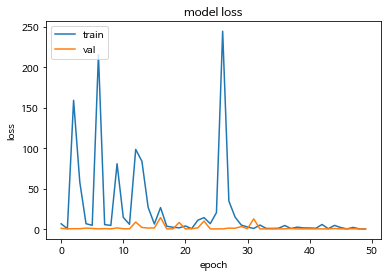

In [11]:
# summarize history loss
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
import itertools

# Predictions
feature_cols_test = X_test[col_train]
labels_test = y_test[LABEL].values

y = estimator.predict(np.array(feature_cols_test))
predictions = list(itertools.islice(y, X_train.shape[0]))

y_predict = estimator.predict(np.array(X_test))

In [17]:
pd.DataFrame(scaler.inverse_transform(X_test), columns = [col_train])

급여         가맹점매출  ...       직장인여부_0       직장인여부_1
0       1.033409e+06  1.176890e+06  ...  1.366154e+06  1.023067e+06
1       1.033409e+06  1.176890e+06  ...  1.366154e+06  1.023067e+06
2       1.033409e+06  1.176890e+06  ...  1.366154e+06  1.023067e+06
3       1.033409e+06  1.176890e+06  ...  1.366154e+06  1.023067e+06
4       1.033409e+06  1.176890e+06  ...  1.366154e+06  1.023067e+06
...              ...           ...  ...           ...           ...
311866  1.033409e+06  1.176890e+06  ...  1.366154e+06  1.023067e+06
311867  1.033409e+06  1.176890e+06  ...  1.366154e+06  1.023067e+06
311868  1.033409e+06  1.176890e+06  ...  1.366154e+06  1.023067e+06
311869  1.033409e+06  1.176890e+06  ...  1.366154e+06  1.023067e+06
311870  1.033409e+06  1.176890e+06  ...  1.366154e+06  1.023067e+06

[311871 rows x 562 columns]

In [13]:
predictions = scaler.inverse_transform(np.array(predictions).reshape(311871,1))
reality = pd.DataFrame(scaler.inverse_transform(y_test), columns = [LABEL])[LABEL]

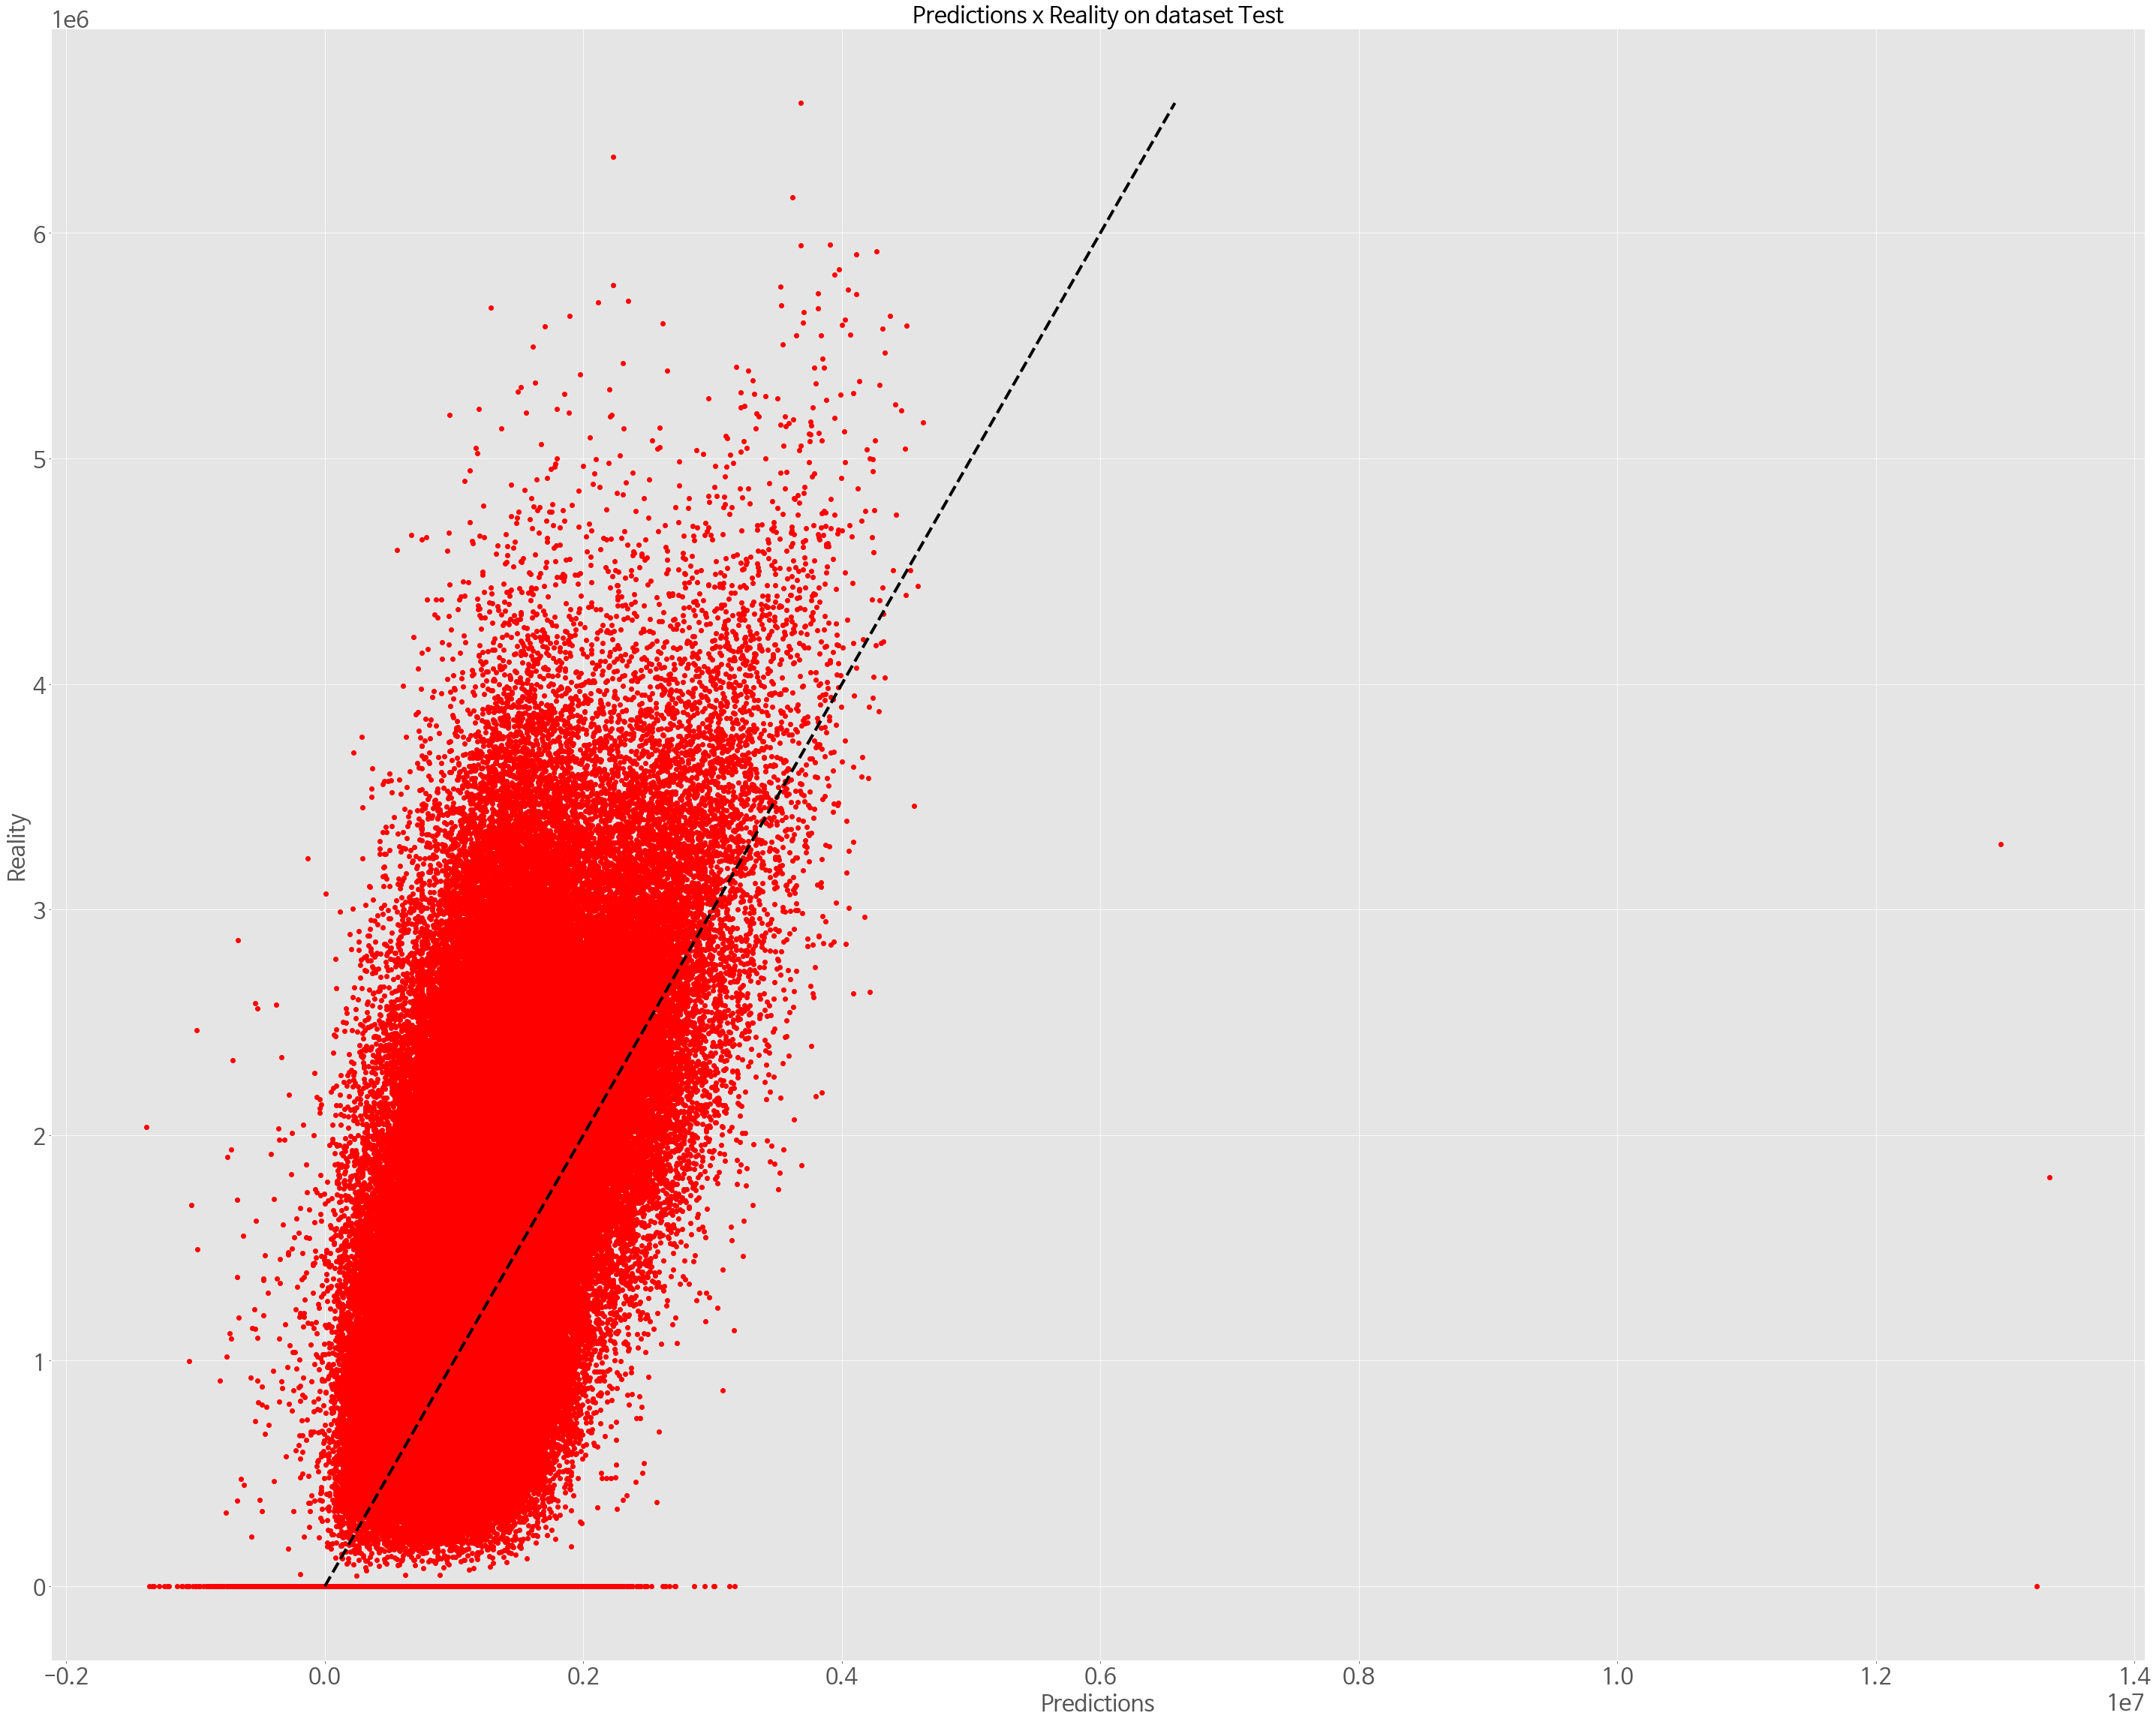

In [20]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions, reality, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

In [ ]:
import xgboost
from sklearn.metrics import mean_squared_error

model = xgboost.XGBRegressor(tree_method = "gpu_hist")

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_pred,y_test)
print(np.sqrt(mse))

[01:17:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
739174.3839125335


MSE: 546378769832.47
RMSE: 739174.38


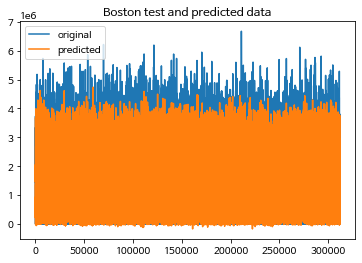

In [ ]:

print("MSE: %.2f" % mse)
MSE: 3.35
print("RMSE: %.2f" % (mse**(1/2.0)))
RMSE: 1.83 

#Finally, we'll visualize the original and predicted test data in a plot to compare visually.

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Boston test and predicted data")
plt.legend()
plt.show()

0.36780089152587947
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

In [ ]:
import time

seed=3
# create a default XGBoost classifier
model = xgboost.XGBRegressor(tree_method = "gpu_hist")

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(model,
                        parameters,
                        cv = 2,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)







Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 10.2min finished


0.36780089152587947
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


NameError: ignored

In [ ]:
# fit grid search
%time best_model = xgb_grid.fit(X_train,y_train)

y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_pred,y_test)
print(np.sqrt(mse))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 10.1min finished


CPU times: user 9min 49s, sys: 1min 7s, total: 10min 57s
Wall time: 10min 54s
724546.586583413


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

model = xgboost.XGBRegressor(tree_method = "gpu_hist")

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )


TerminatedWorkerError: ignored

## Functions: *mean_groupby_dong* and *map_data_preprocessing*

In [ ]:
# making mean data and map data

def mean_groupby_dong(path, data): 
  """
Requirements: 
1. '서울행정구역분류_20210701.csv'
2. preprocessed data

Input: directory as path, preprocessed data
Output: dongmean
  """
  ## c= data.merge(행정구역[['법정동코드','행정구역코드','행정동(행정기관명)']].drop_duplicates(subset='법정동코드', keep='first'), on='법정동코드')
  행정구역 = pd.read_csv(path+'서울행정구역분류_20210701.csv')
  행정구역 = 행정구역.apply(pd.to_numeric , errors='ignore')
  행정구역['법정동코드'] = 행정구역['법정동코드'].astype(int)
  행정구역['행정구역코드'] = 행정구역['행정구역코드'].astype(int)
  map_data=  data.merge(행정구역[['법정동코드','행정구역코드', '행정동(행정기관명)']], on='법정동코드')
  dongmean = map_data.groupby(['기준년월', 'time' ,'행정구역코드']).mean().reset_index() # group by location and time and make mean data : dongmean
  dongmean['행정구역코드']=dongmean['행정구역코드'].astype(str)
  return dongmean



def map_data_preprocessing(path, dongmean):
  """
Requirements: 
1. 'HangJeongDong_ver20210401.geojson'
2. dongmean, or the output of the mean_groupby_dong() function.

Input: directory as path, dongmean
Output: 행정구역_gdf
# 
Use geopandas to load a dataset containing the dong_shape
  """
  # use geopandas to make geopandas df
  dong_shape = gpd.read_file(path+'HangJeongDong_ver20210401.geojson')
  dong_shape['행정구역코드'] = dong_shape['adm_cd']
  # merge on 행정구역
  dongmean_polygon = dongmean.merge(dong_shape[['geometry','행정구역코드']], on='행정구역코드') # dongmean_polygon
  # Take the polygons of the merged data and make into GeoDataFrame. The 행정구역_gdf index matches that of dongmean
  행정구역_df = dongmean_polygon[['geometry']]
  행정구역_gdf = gpd.GeoDataFrame(행정구역_df)
  행정구역_gdf = 행정구역_gdf.drop_duplicates().reset_index() # 행정구역_gdf
  return 행정구역_gdf, dongmean_polygon

In [ ]:
# Execute function

dongmean = mean_groupby_dong(path, data)
행정구역_gdf, dongmean_polygon = map_data_preprocessing(path, dongmean)

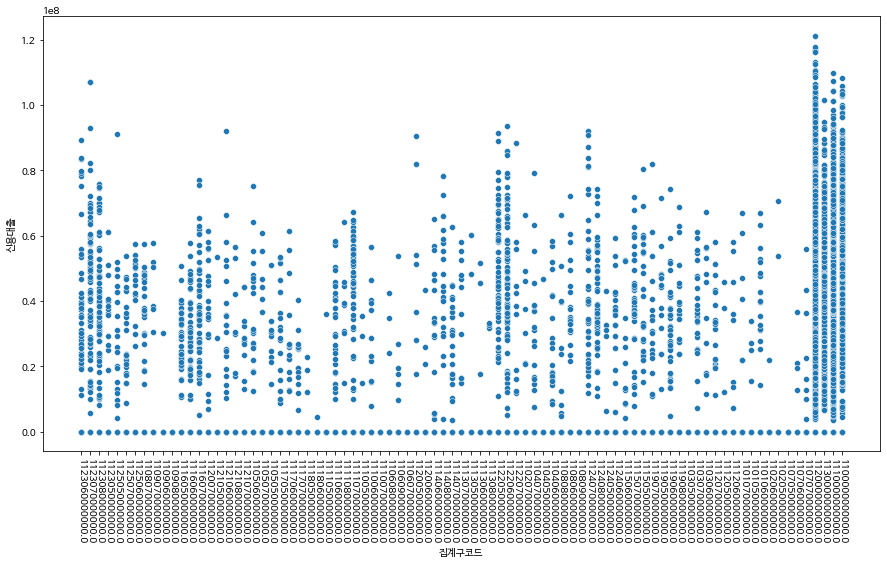

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(data['집계구코드'], data['신용대출'])
plt.xticks(rotation=-90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



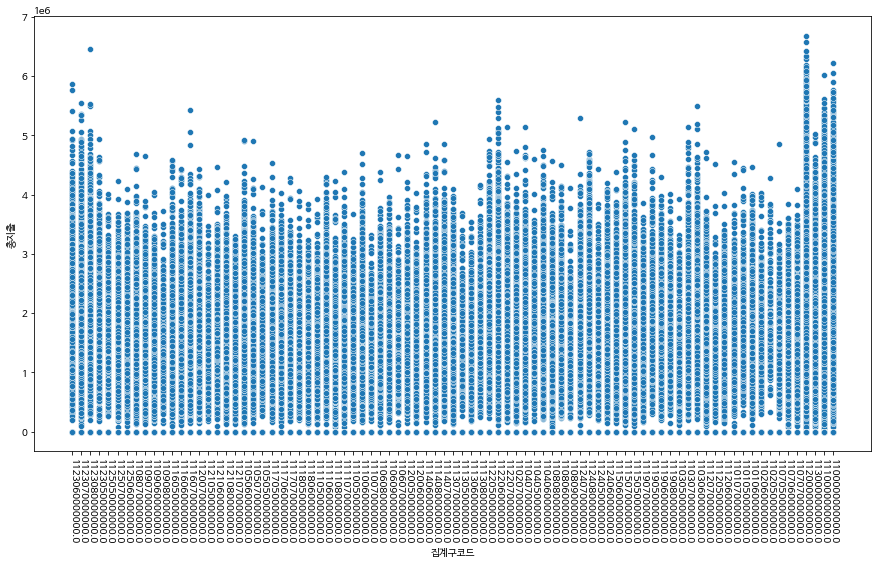

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



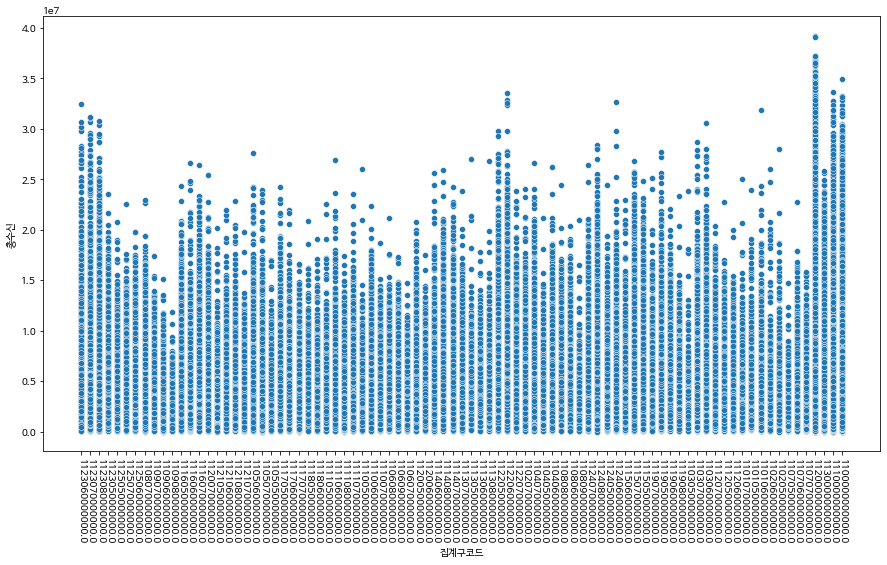

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



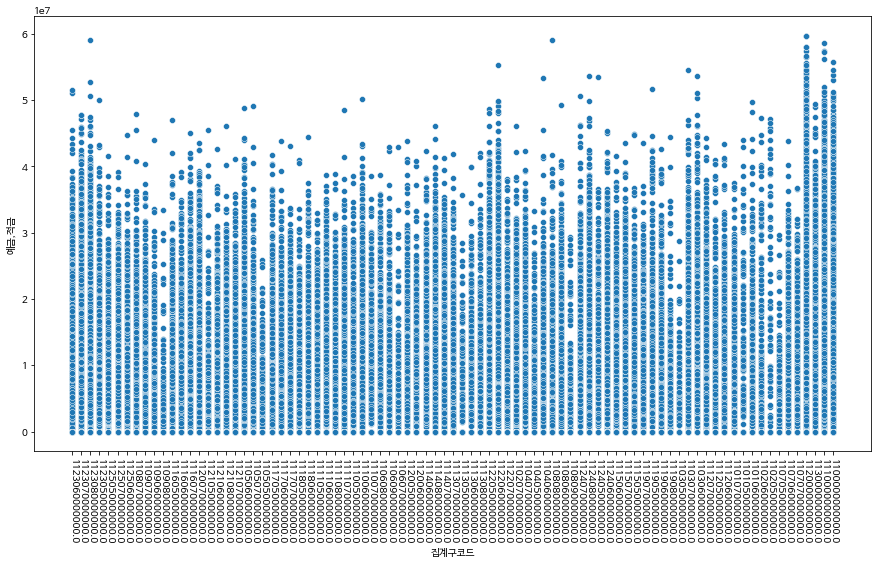

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(data['집계구코드'], data['총지출']) 
plt.xticks(rotation=-90)
plt.show()

plt.figure(figsize=(15,8))
sns.scatterplot(data['집계구코드'], data['총수신'])
plt.xticks(rotation=-90)
plt.show()

plt.figure(figsize=(15,8))
sns.scatterplot(data['집계구코드'], data['예금,적금']) 
plt.xticks(rotation=-90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



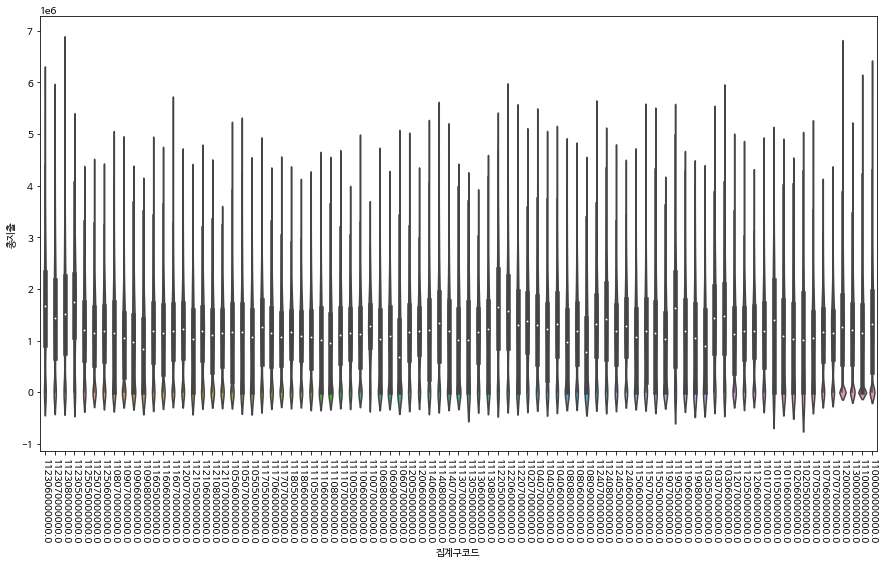

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



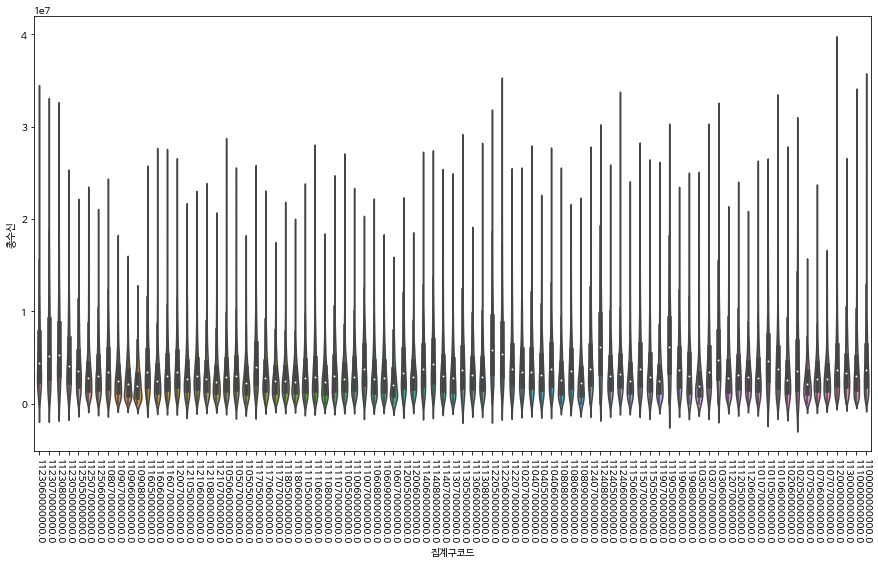

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



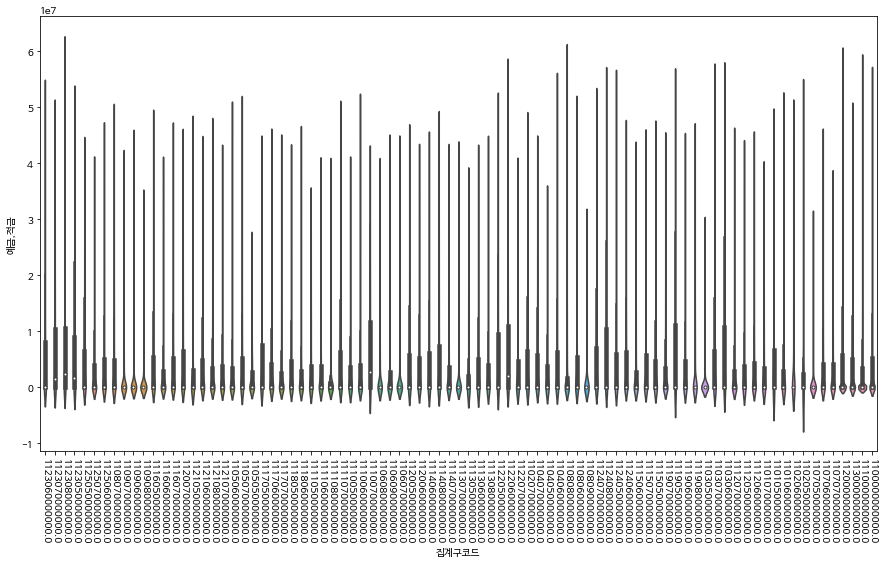

In [ ]:

special = data[(data['집계구코드']=='1100000000000.0') | (data['집계구코드']== '1110000000000.0')| (data['집계구코드']=='1120000000000.0') |(data['집계구코드']=='1130000000000.0') ]
special.to_csv(path+'special.csv')

In [ ]:
data.describe()

기준년월         법정동코드  ...          주택대출          전세대출
count  1.039568e+06  1.039568e+06  ...  1.039568e+06  1.039568e+06
mean   2.019865e+05  1.145229e+09  ...  1.593375e+05  2.736704e+05
std    7.397536e+01  1.789507e+07  ...  5.789683e+06  5.707165e+06
min    2.019030e+05  1.111010e+09  ...  0.000000e+00  0.000000e+00
25%    2.019090e+05  1.130510e+09  ...  0.000000e+00  0.000000e+00
50%    2.020030e+05  1.147010e+09  ...  0.000000e+00  0.000000e+00
75%    2.020090e+05  1.162010e+09  ...  0.000000e+00  0.000000e+00
max    2.021030e+05  1.174011e+09  ...  3.821344e+08  2.328000e+08

[8 rows x 17 columns]

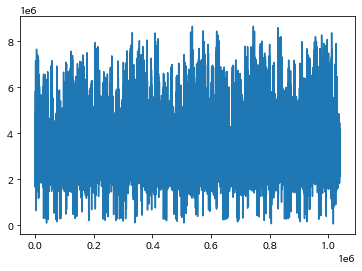

In [ ]:
data[data['직장인여부']==1]['급여'].plot()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



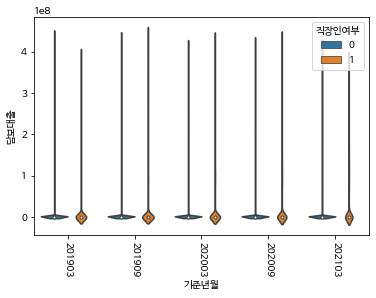

In [ ]:
ax=sns.violinplot(data['기준년월'], data['담보대출'], data=data, hue='직장인여부', height=8.27, aspect=11.7/8.27)
plt.xticks(rotation=-90)
plt.show()

In [ ]:
from scipy import stats

ax=sns.histplot(x = stats.boxcox(data['급여']), data=data[(data['기준년월']==201903) & (data['법정동코드']==1168010100)], hue='직장인여부')
ax.ticklabel_format(style='plain')
plt.show()

ValueError: ignored

# Visualizing with plots

## Simple plots

For monetary features such as 급여, 가맹점매출, 연금, etc, the data is highly skewed. 


In [ ]:
zeros = data[(data['총지출']==0) | 
               (data['집계구코드']== 0)| 
               (data['집계구코드']==0) |
               (data['집계구코드']==0) ]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9745a7e610>,
      dtype=object)

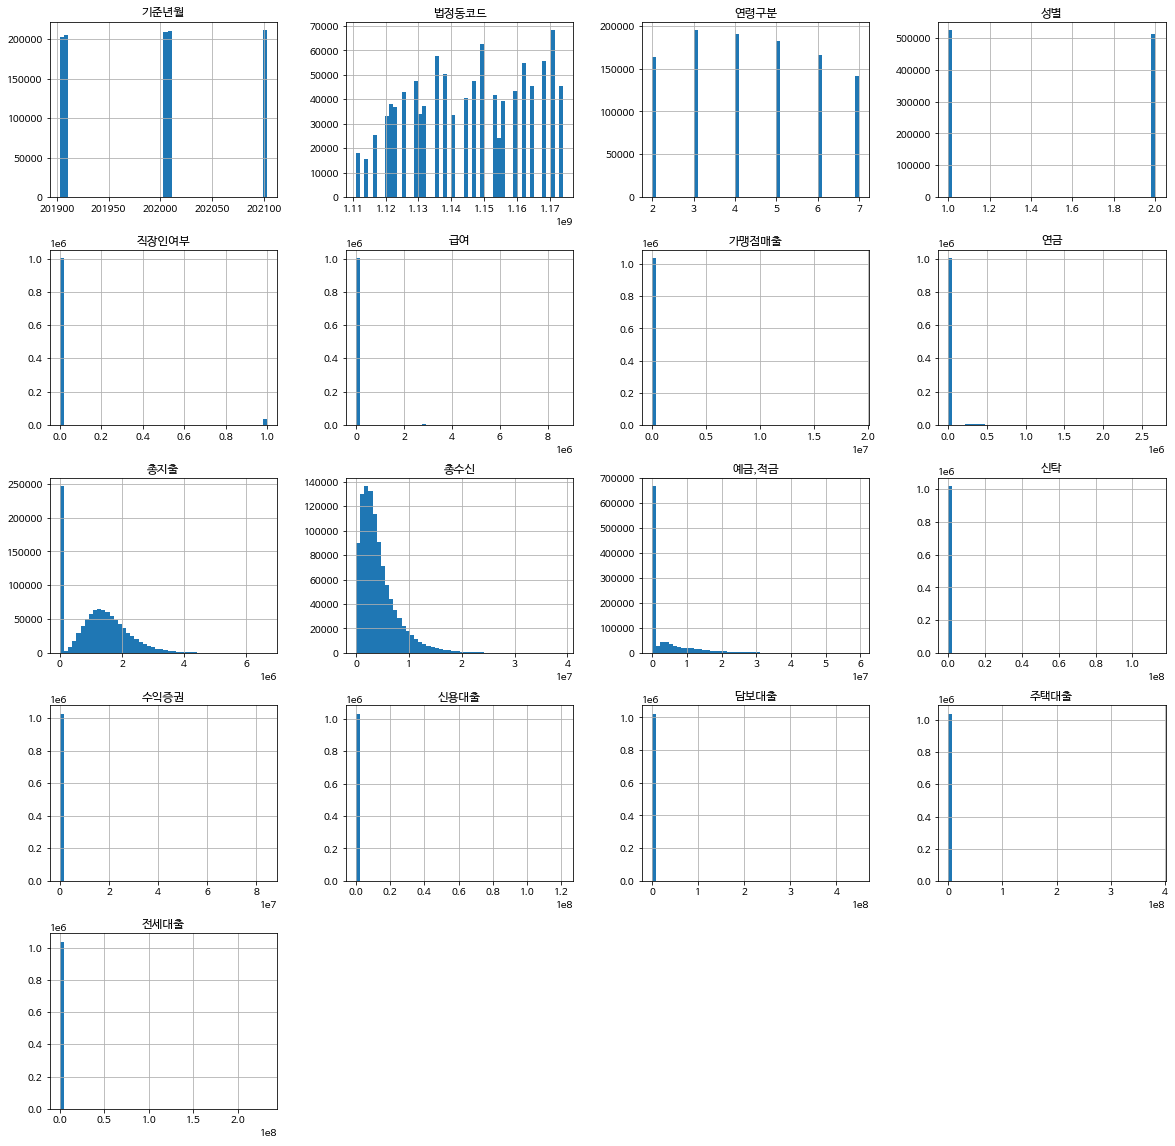

In [ ]:
data.hist(figsize=(20,20), bins=50)

## Counts of categorical features 

Categorical features such as 법정동코드, 연령구분, 성별, 직장인 여부, 집계구코드 are shown here. 

The majority of the data have the following 집계구코드 
* 1120000000000.0 
* 1110000000000.0   
* 1100000000000.0     
* 1130000000000.0

The majority of the data are under 직장인.


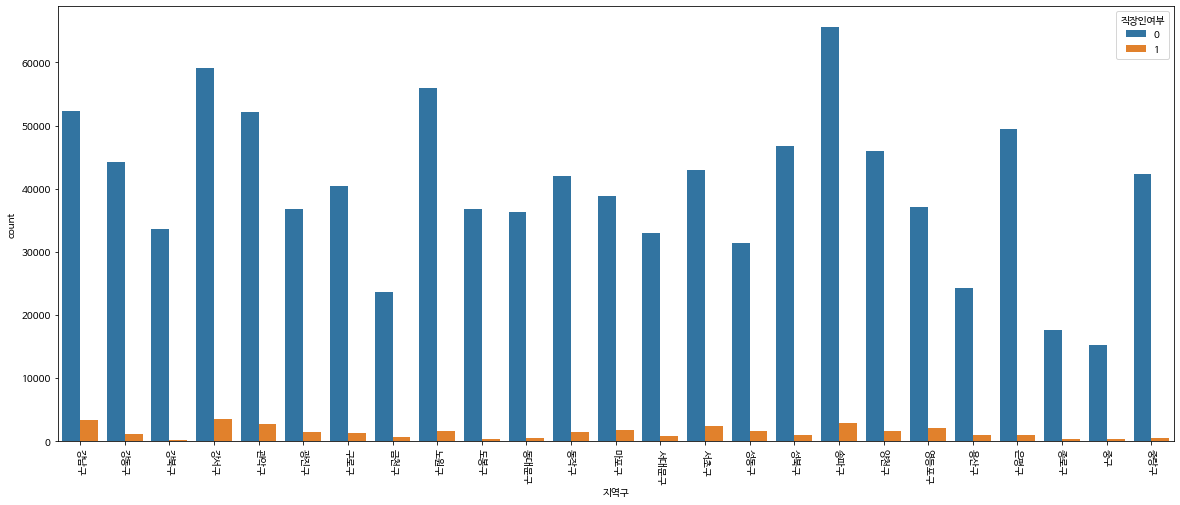

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(x='지역구',  data=data,  hue='직장인여부')
plt.xticks(rotation=-90)
plt.show()

<Figure size 1440x576 with 0 Axes>

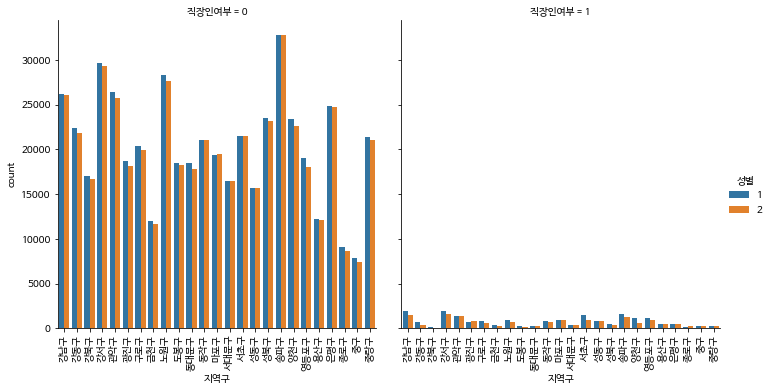

In [ ]:
plt.figure(figsize=(20,8))
g = sns.catplot(x="지역구", hue='성별', col='직장인여부',
                data=data, kind="count")
g.set_xticklabels(rotation=90)
plt.show()

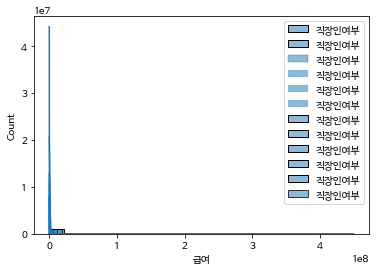

In [ ]:
num_features=['급여',	'가맹점매출',	'연금',	'총지출',	'총수신',	'예금,적금'	,'신탁',	'수익증권'	,'신용대출',	'담보대출',	'주택대출',	'전세대출']

for col in num_features:
    sns.histplot(data=data, x=data[col], label="직장인여부", kde=True)
plt.legend() 
plt.show()

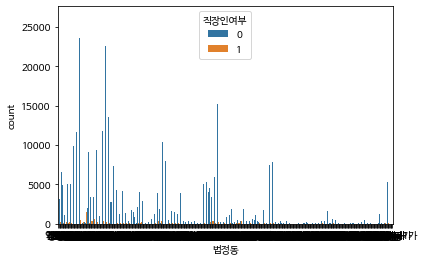

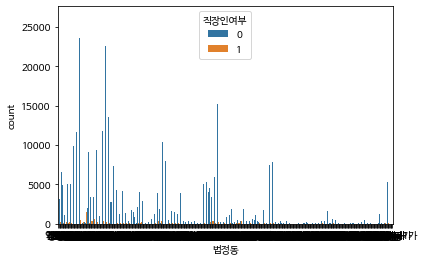

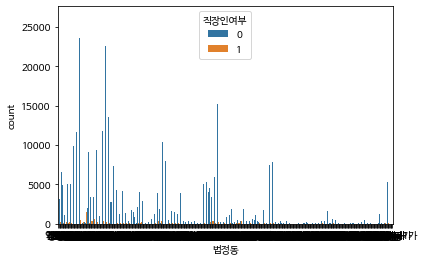

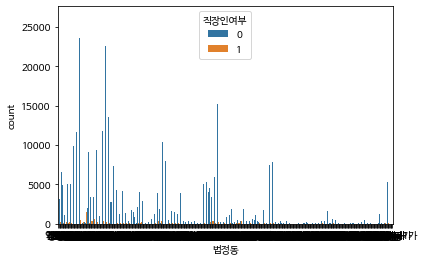

KeyboardInterrupt: ignored

In [6]:
cat_features=['지역구', '법정동코드', '법정동','집계구코드', '연령구분', '성별', '직장인여부']
for col in cat_features: 
  sns.countplot(x='법정동',  data=data,  hue='직장인여부')
  plt.show()

In [7]:
cat_features=['기준년월','지역구', '법정동코드', '법정동','집계구코드', '연령구분', '성별', '직장인여부']

for col in cat_features: 
    try:      
        print("---- %s ---" % col)
        print(data[col].value_counts(dropna=False))
        print("\n")
    except ValueError:
        print('This column can not be represented. Check datatype')

---- 기준년월 ---
202103    211886
202009    210307
202003    208936
201909    204949
201903    203490
Name: 기준년월, dtype: int64


---- 지역구 ---
송파구     68405
강서구     62611
노원구     57599
강남구     55601
관악구     54845
은평구     50430
양천구     47630
성북구     47630
서초구     45404
강동구     45341
동작구     43572
중랑구     42952
구로구     41700
마포구     40649
영등포구    39104
광진구     38192
도봉구     37119
동대문구    36774
강북구     33833
서대문구    33733
성동구     33053
용산구     25326
금천구     24284
종로구     18127
중구      15654
Name: 지역구, dtype: int64


---- 법정동코드 ---
1162010200    27423
1162010100    25258
1150010300    24449
1135010500    23231
1147010100    18652
              ...  
1111015100        7
1111013800        5
1150011100        3
1114010600        1
1114012300        1
Name: 법정동코드, Length: 453, dtype: int64


---- 법정동 ---
신림동       27423
봉천동       25258
화곡동       24449
상계동       23231
신정동       18851
          ...  
묘동            7
종로2가          5
과해동           3
회현동3가         1
남대문로1가        1
Name: 법정동, Length: 4

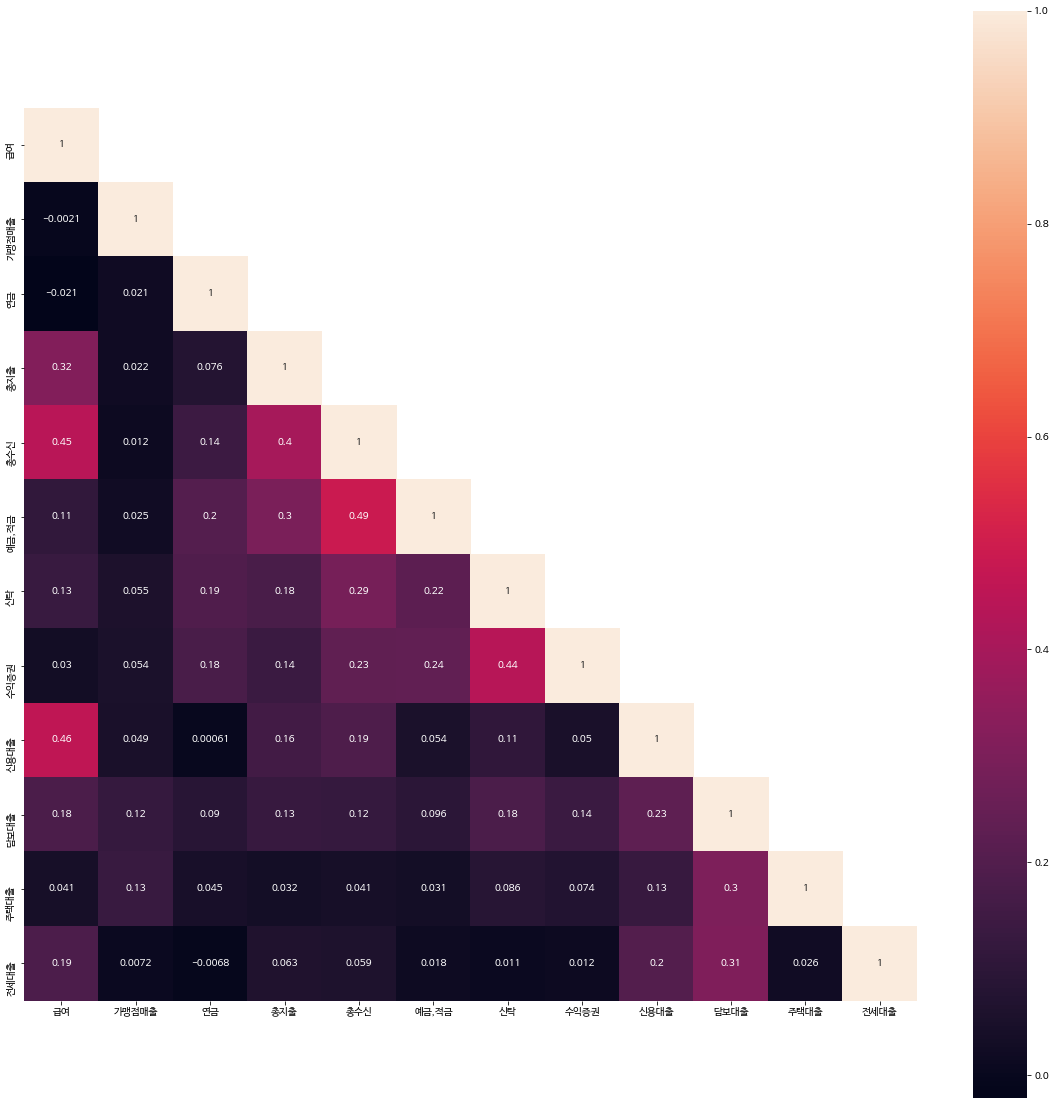

In [8]:
num_features=['급여',	'가맹점매출',	'연금',	'총지출',	'총수신',	'예금,적금'	,'신탁',	'수익증권'	,'신용대출',	'담보대출',	'주택대출',	'전세대출']

corrmat = data[num_features].corr()
mask = np.array(corrmat)
mask[np.tril_indices_from(mask)]=False
plt.subplots(figsize=(20,20))
sns.heatmap(corrmat, mask=mask, annot = True, square=True)

c = corrmat.abs()

s = c.unstack()
so = s.sort_values(ascending=True).drop_duplicates()

In [11]:
# Pair plot
sns.pairplot(data_cat[num_features])

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff7109dff80> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7ff70f8dbdd0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
from matplotlib import cm
colors = cm.get_cmap('rainbow')

In [ ]:
data_detail_type = data.groupby(['time','연령구분'])['총지출'].agg('mean')
ax1 = data_detail_type.unstack('연령구분', fill_value=0).plot(figsize=(15,8)).set_ylabel('연령구분 별 총 총지출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

data_more_detail_type = data.groupby(['time','지역구'])['총지출'].agg('mean')
ax2 = data_more_detail_type.unstack('지역구', fill_value=0).plot(figsize=(15,8), cmap=colors).set_ylabel('지역구 별 총 총지출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))

data_dong_type = data.groupby(['time','법정동'])['총지출'].agg('mean')
ax3 = data_dong_type.unstack('법정동', fill_value=0).plot(figsize=(15,8), cmap=colors).set_ylabel('법정동 별 총 총지출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

data_행정구역_type = c.groupby(['time','행정동(행정기관명)'])['총지출'].agg('mean')
ax3 = data_행정구역_type.unstack('행정동(행정기관명)', fill_value=0).plot(figsize=(15,8), cmap=colors).set_ylabel('법정동 별 총 총지출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

data_age_type = data.groupby(['time','집계구코드'])['총지출'].agg('mean')
ax4 = data_age_type.unstack('집계구코드', fill_value=0).plot(figsize=(15,8)).set_ylabel('집계구코드 별 총 총지출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

data_age_type = data.groupby(['time','직장인여부'])['총지출'].agg('mean')
ax4 = data_age_type.unstack('직장인여부', fill_value=0).plot(figsize=(15,8)).set_ylabel('직장인여부 별 총 총지출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

Output hidden; open in https://colab.research.google.com to view.

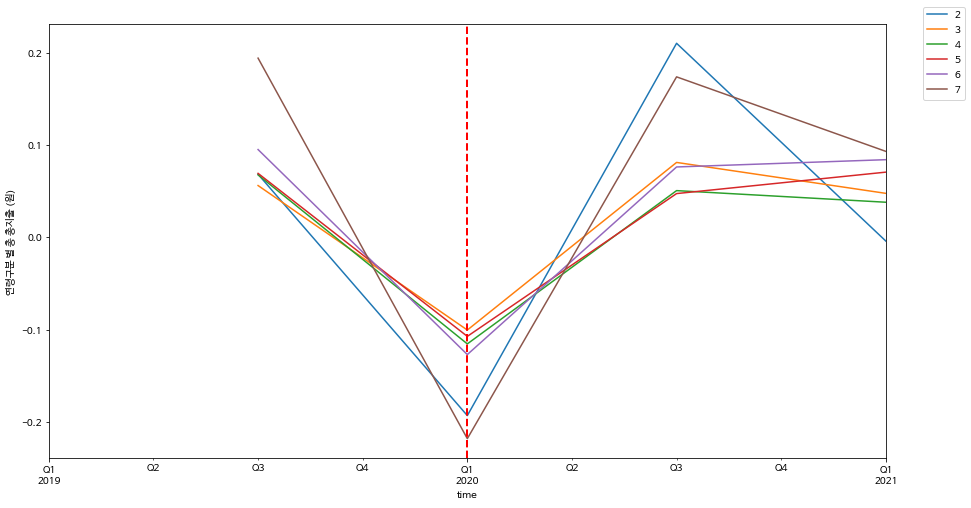

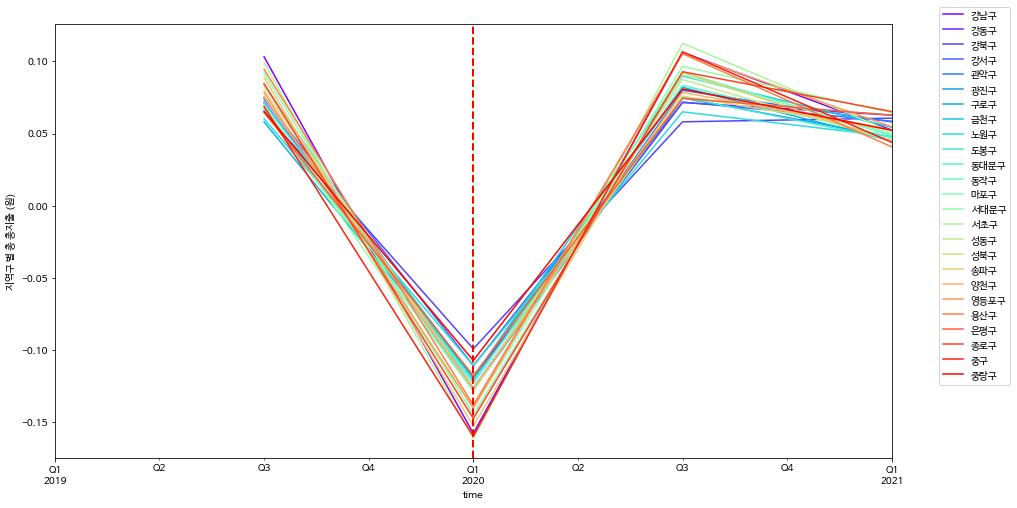

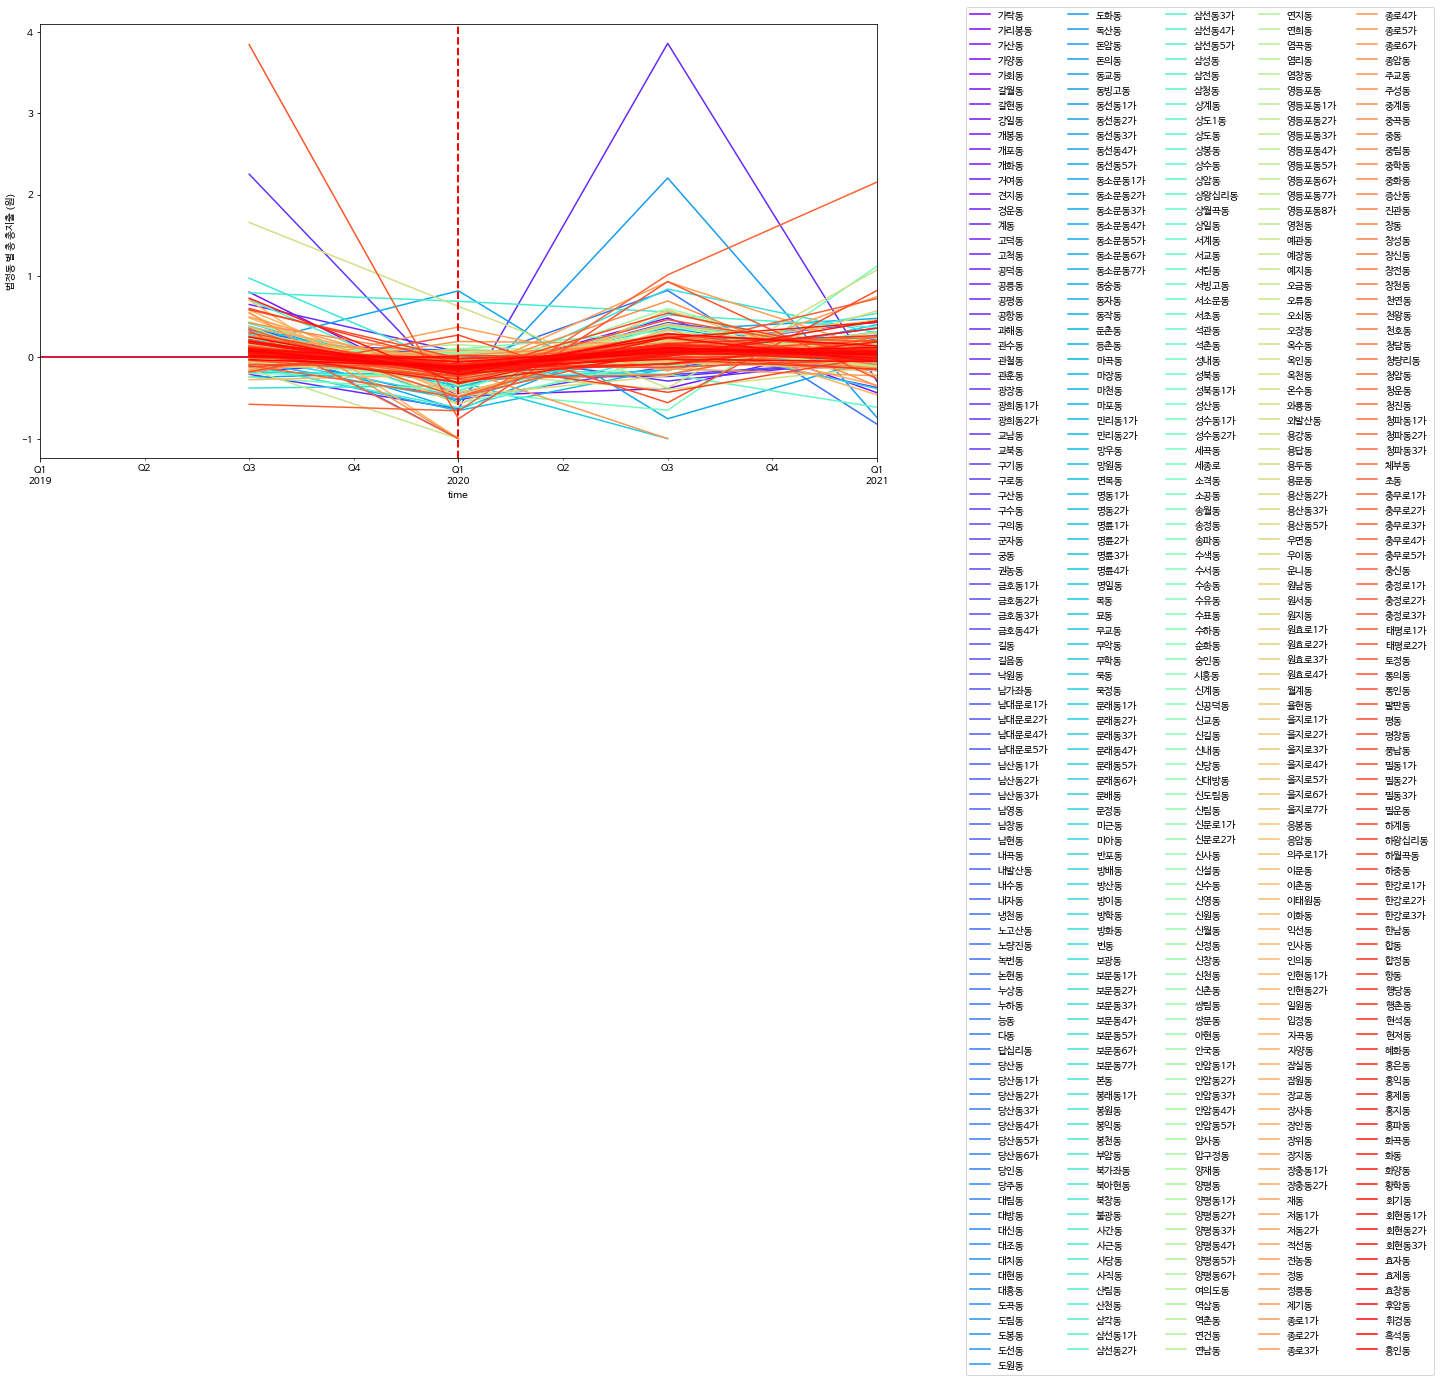

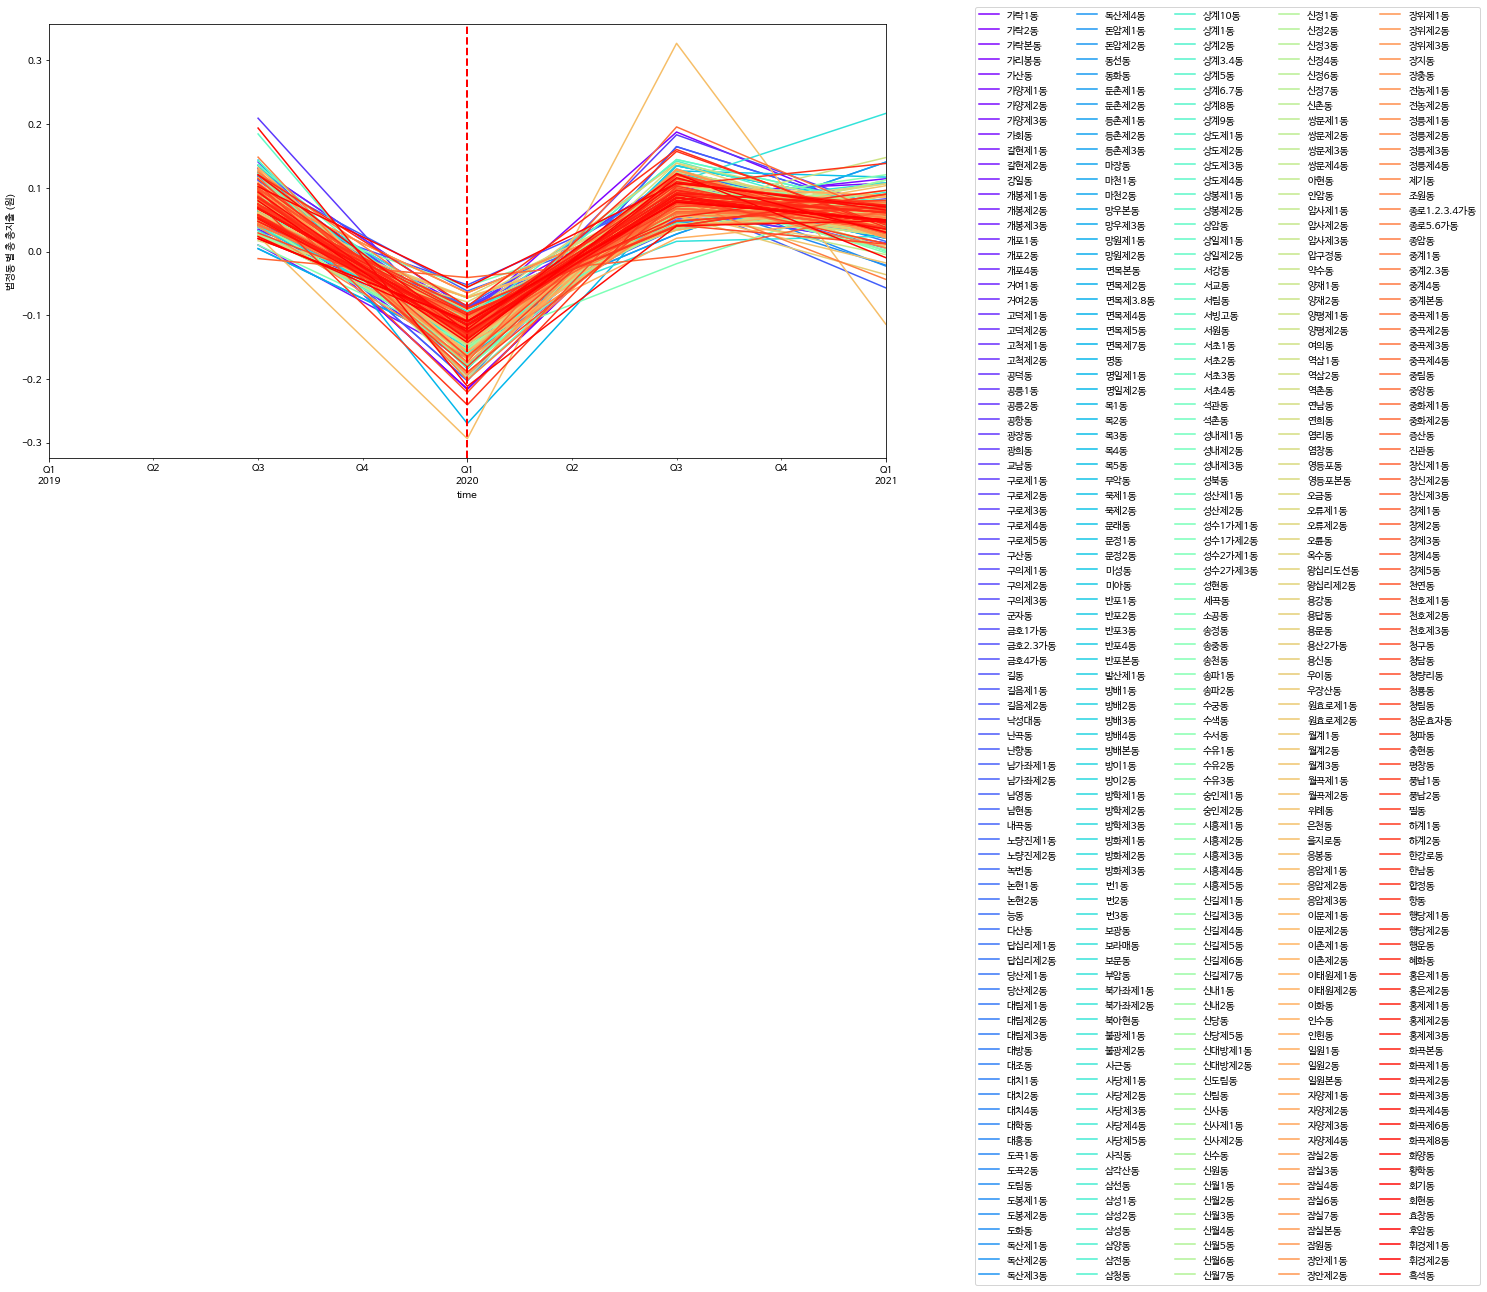

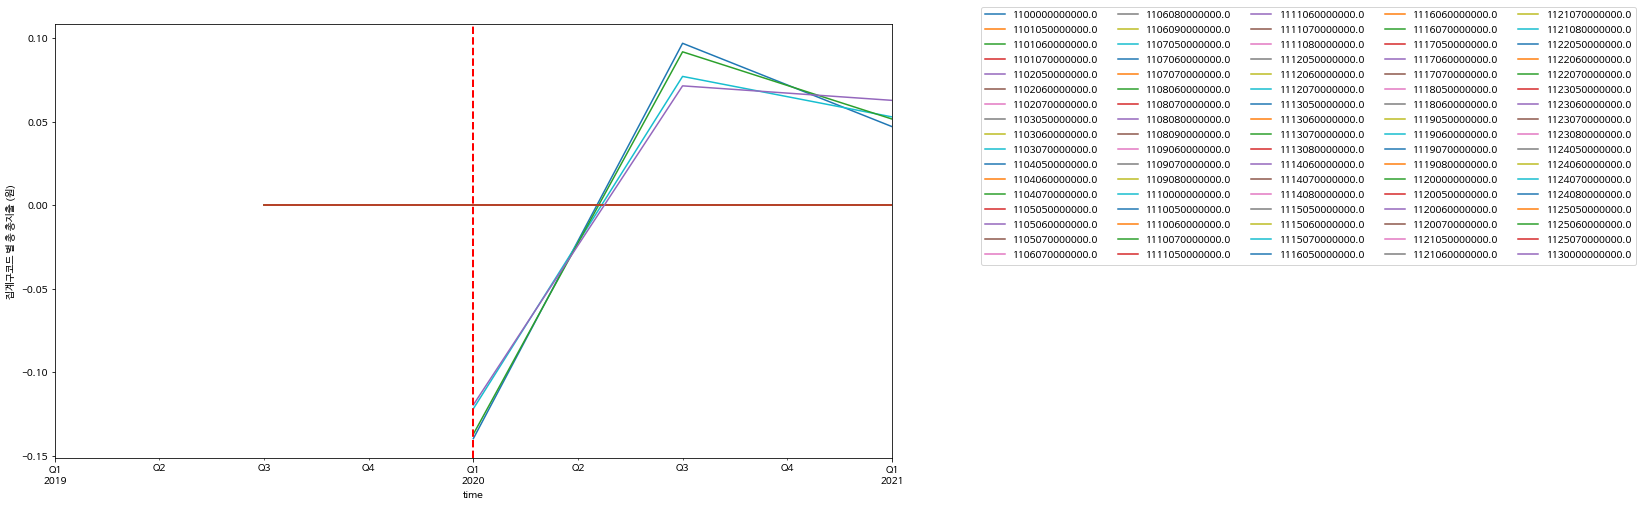

In [ ]:
data_detail_type = data.groupby(['time','연령구분'])['총지출'].agg('mean').groupby(['연령구분']).pct_change()
ax1 = data_detail_type.unstack('연령구분', fill_value=0).plot(figsize=(15,8)).set_ylabel('연령구분 별 총 총지출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

data_more_detail_type = data.groupby(['time','지역구'])['총지출'].agg('mean').groupby(['지역구']).pct_change()
ax2 = data_more_detail_type.unstack('지역구', fill_value=0).plot(figsize=(15,8), cmap=colors).set_ylabel('지역구 별 총 총지출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))

data_dong_type = data.groupby(['time','법정동'])['총지출'].agg('mean').groupby(['법정동']).pct_change()
ax3 = data_dong_type.unstack('법정동', fill_value=0).plot(figsize=(15,8), cmap=colors).set_ylabel('법정동 별 총 총지출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

data_행정구역_type = c.groupby(['time','행정동(행정기관명)'])['총지출'].agg('mean').groupby(['행정동(행정기관명)']).pct_change()
ax3 = data_행정구역_type.unstack('행정동(행정기관명)', fill_value=0).plot(figsize=(15,8), cmap=colors).set_ylabel('법정동 별 총 총지출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

data_age_type = data.groupby(['time','집계구코드'])['총지출'].agg('mean').groupby(['집계구코드']).pct_change()
ax4 = data_age_type.unstack('집계구코드', fill_value=0).plot(figsize=(15,8)).set_ylabel('집계구코드 별 총 총지출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

In [ ]:
data_detail_type = data.groupby(['time','집계구코드'])['총지출'].agg('mean').groupby(['집계구코드']).pct_change()

In [ ]:
data_detail_type 

time        집계구코드          
2019-03-01  1101050000000.0         NaN
            1101060000000.0         NaN
            1101070000000.0         NaN
            1102050000000.0         NaN
            1102060000000.0         NaN
                                 ...   
2020-09-01  1130000000000.0    0.071466
2021-03-01  1100000000000.0    0.047101
            1110000000000.0    0.052902
            1120000000000.0    0.051627
            1130000000000.0    0.062791
Name: 총지출, Length: 97, dtype: float64

In [ ]:
data_detail_type = data.groupby(['time','연령구분'])['급여'].agg('mean')
ax1 = data_detail_type.unstack('연령구분', fill_value=0).plot(figsize=(22,12)).set_ylabel('연령구분 별 총 평균 급여 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

data_more_detail_type = data.groupby(['time','지역구'])['급여'].agg('mean')
ax2 = data_more_detail_type.unstack('지역구', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('지역구 별 총 총평균 급여(원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))

data_dong_type = data.groupby(['time','법정동'])['급여'].agg('mean')
ax3 = data_dong_type.unstack('법정동', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('법정동 별 총 평균 급여 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

data_행정구역_type = c.groupby(['time','행정동(행정기관명)'])['급여'].agg('mean')
ax3 = data_행정구역_type.unstack('행정동(행정기관명)', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('법정동 별 총 급여 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

data_age_type = data.groupby(['time','집계구코드'])['급여'].agg('mean')
ax4 = data_age_type.unstack('집계구코드', fill_value=0).plot(figsize=(22,12)).set_ylabel('집계구코드 별 총 평균 급여 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data_detail_type = data.groupby(['time','연령구분'])['예금,적금'].agg('mean')
ax1 = data_detail_type.unstack('연령구분', fill_value=0).plot(figsize=(22,12)).set_ylabel('연령구분 별 총 평균 예금,적금 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

data_more_detail_type = data.groupby(['time','지역구'])['예금,적금'].agg('mean')
ax2 = data_more_detail_type.unstack('지역구', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('지역구 별 총 총평균 예금,적금(원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))

data_dong_type = data.groupby(['time','법정동'])['예금,적금'].agg('mean')
ax3 = data_dong_type.unstack('법정동', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('법정동 별 총 평균 예금,적금 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

data_행정구역_type = map_data.groupby(['time','행정동(행정기관명)'])['예금,적금'].agg('mean')
ax3 = data_행정구역_type.unstack('행정동(행정기관명)', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('법정동 별 총 예금,적금 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

data_age_type = data.groupby(['time','집계구코드'])['예금,적금'].agg('mean')
ax4 = data_age_type.unstack('집계구코드', fill_value=0).plot(figsize=(22,12)).set_ylabel('집계구코드 별 총 평균 예금,적금 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data_detail_type = data.groupby(['time','연령구분'])['신용대출'].agg('mean')
ax1 = data_detail_type.unstack('연령구분', fill_value=0).plot(figsize=(22,12)).set_ylabel('연령구분 별 총 평균 신용대출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

data_more_detail_type = data.groupby(['time','지역구'])['신용대출'].agg('mean')
ax2 = data_more_detail_type.unstack('지역구', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('지역구 별 총 총평균 신용대출(원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))

data_dong_type = data.groupby(['time','법정동'])['신용대출'].agg('mean')
ax3 = data_dong_type.unstack('법정동', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('법정동 별 총 평균 신용대출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

data_행정구역_type = map_data.groupby(['time','행정동(행정기관명)'])['신용대출'].agg('mean')
ax3 = data_행정구역_type.unstack('행정동(행정기관명)', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('법정동 별 총 신용대출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

data_age_type = data.groupby(['time','집계구코드'])['신용대출'].agg('mean')
ax4 = data_age_type.unstack('집계구코드', fill_value=0).plot(figsize=(22,12)).set_ylabel('집계구코드 별 총 평균 신용대출 (원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!wget -O "/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson" https://github.com/vuski/admdongkor/raw/master/ver20210401/HangJeongDong_ver20210401.geojson

In [ ]:
!pip install geopandas

     |████████████████████████████████| 994 kB 30.1 MB/s 
     |████████████████████████████████| 6.6 MB 44.1 MB/s 
     |████████████████████████████████| 15.4 MB 84 kB/s 


# 평균 지출
## 지도로 시각화하기 위한 데이터 processing

시기별로 구/동 별로 평균한 개인 총 지출 급여를 계산하여, dictionary 로 저장

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean총지출=map_data[map_data['기준년월']==year ].groupby('행정구역코드')['총지출'].mean().reset_index()
  dongmean총지출['행정구역코드']=dongmean총지출['행정구역코드'].astype(str)
  appended_data_dong[year] = dongmean총지출

appended_data_gu={}
for i, year in enumerate(times):
  gumean총지출=data[data['기준년월']==year ].groupby('지역구')['총지출'].mean().reset_index()
  gumean총지출['지역구']=gumean총지출['지역구'].astype(str)
  appended_data_gu[year] = gumean총지출

## 구를 기준으로 평균 지출를 지도로 시각화

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/skorea-municipalities-2018-geo.json'
geo_str = json.load(open(geo_path ,encoding='utf-8'))


directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/gumean총지출/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_gu.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('지역구', '총지출'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='구 평균 총지출',
                nan_fill_color = "White",
                threshold_scale=[0, 500000, 1000000, 1500000, 2000000, 2500000],
                key_on='properties.name').add_to(map)
  folium.LayerControl().add_to(map)
  map.save(directory+'plot_gumean총지출_{0}.html'.format(year))

  #display(map)


## 동를 기준으로 평균 지출를 지도로 시각화

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean총지출/'

if not os.path.exists(directory):
  os.makedirs(directory)


for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '총지출'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 총지출',
                nan_fill_color = "White",
                threshold_scale=[0, 500000, 1000000, 1500000, 2000000, 2500000],
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean총지출_{0}.html'.format(year))

  #display(map)

# 평균 수신

## 동를 기준으로 평균 수신를 지도로 시각화

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean총수신=c[c['기준년월']==year ].groupby('행정구역코드')['총수신'].mean().reset_index()
  dongmean총수신['행정구역코드']=dongmean총수신['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean총수신


In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean총수신/'

if not os.path.exists(directory):
  os.makedirs(directory)


for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '총수신'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 총수신',
                nan_fill_color = "White",
                #threshold_scale=[0, 500000, 1000000, 1500000, 2000000, 2500000],
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean총수신_{0}.html'.format(year))

# 평균 급여
## 지도로 시각화하기 위한 데이터 processing

시기별로 구/동 별로 평균 급여를 계산하여, dictionary 로 저장

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean급여=c[c['기준년월']==year ].groupby('행정구역코드')['급여'].mean().reset_index()
  dongmean급여['행정구역코드']=dongmean급여['행정구역코드'].astype(str)
  appended_data_dong[year] = dongmean급여

appended_data_gu={}
for i, year in enumerate(times):
  gumean급여=data[data['기준년월']==year ].groupby('지역구')['급여'].mean().reset_index()
  gumean급여['지역구']=gumean급여['지역구'].astype(str)
  appended_data_gu[year] = gumean급여


## 구를 기준으로 평균한 급여를 지도로 시각화

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/skorea-municipalities-2018-geo.json'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/gumean급여/'

if not os.path.exists(directory):
  os.makedirs(directory)


for year, yearlydata in appended_data_gu.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('지역구', '급여'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='구 평균 급여',
                nan_fill_color = "White",
                threshold_scale=[0, 50000, 100000, 150000, 200000, 250000,300000],
                key_on='properties.name').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_gumean급여_{0}.html'.format(year))


## 행정동을 기준으로 평균한 급여를 지도로 시각화

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean급여/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '급여'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 급여',
                nan_fill_color = "White",
                threshold_scale=[0, 100000, 200000, 300000, 400000, 500000,600000],
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean급여_{0}.html'.format(year))

# 평균 예금/적금
## 지도로 시각화하기 위한 데이터 processing

시기별로 구/동 별로 평균 예금/적금를 계산하여, dictionary 로 저장

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean예금=c[c['기준년월']==year ].groupby('행정구역코드')['예금,적금'].mean().reset_index()
  dongmean예금['행정구역코드']=dongmean예금['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean예금

appended_data_gu={}
for i, year in enumerate(times):
  gumean예금=data[data['기준년월']==year ].groupby('지역구')['예금,적금'].mean().reset_index()
  gumean예금['지역구']=gumean예금['지역구'].astype(str)
  appended_data_gu[year] = gumean예금

447180.5068493151

## 구를 기준으로 평균한 예금/적금를 지도로 시각화

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/skorea-municipalities-2018-geo.json'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/gumean예금/'

if not os.path.exists(directory):
  os.makedirs(directory)


for year, yearlydata in appended_data_gu.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('지역구', '예금,적금'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='구 평균 예금,적금',
                nan_fill_color = "White",
                threshold_scale=range(1800000, 6300000,640000),
                key_on='properties.name').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_gumean예금_{0}.html'.format(year))

## 동를 기준으로 평균한 예금/적금를 지도로 시각화

In [ ]:
list(range(200000, 10000001,1400000))

[200000, 1600000, 3000000, 4400000, 5800000, 7200000, 8600000, 10000000]

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/연습'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '예금,적금'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 예금,적금',
                nan_fill_color = "Grey",
                threshold_scale=list(range(200000, 10000001,1400000)),
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean예금_{0}.html'.format(year))

# 신용대출

## 동를 기준으로 평균한 신용대출 지도로 시각화

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean신용대출=c[c['기준년월']==year ].groupby('행정구역코드')['신용대출'].mean().reset_index()
  dongmean신용대출['행정구역코드']=dongmean신용대출['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean신용대출


In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean신용대출/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '신용대출'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 신용대출',
                nan_fill_color = "Grey",
                threshold_scale=list(np.linspace(0, 4000000,7)),
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean신용대출_{0}.html'.format(year))


# 신탁

## 동를 기준으로 평균한 신탁 지도로 시각화

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean신탁=c[c['기준년월']==year ].groupby('행정구역코드')['신탁'].mean().reset_index()
  dongmean신탁['행정구역코드']=dongmean신탁['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean신탁


In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean신탁/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '신탁'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 신탁',
                nan_fill_color = "Grey",
                # threshold_scale=list(np.linspace(0, 4000000,7)),
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean신탁_{0}.html'.format(year))

# 수익증권

## 동를 기준으로 평균한 수익증권 지도로 시각화

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean수익증권=c[c['기준년월']==year ].groupby('행정구역코드')['수익증권'].mean().reset_index()
  dongmean수익증권['행정구역코드']=dongmean수익증권['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean수익증권

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean수익증권/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '수익증권'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 수익증권',
                nan_fill_color = "Grey",
                # threshold_scale=list(np.linspace(0, 4000000,7)),
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean수익증권_{0}.html'.format(year))

# 담보대출

동를 기준으로 평균한 담보대출 지도로 시각화

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean담보대출=dongmean[dongmean['기준년월']==year ].groupby('행정구역코드')['담보대출'].mean().reset_index()
  dongmean담보대출['행정구역코드']=dongmean담보대출['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean담보대출

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean담보대출/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '담보대출'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 담보대출',
                nan_fill_color = "Grey",
                # threshold_scale=list(np.linspace(0, 4000000,7)),
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean담보대출_{0}.html'.format(year))

# 주택대출

동를 기준으로 평균한 주택대출 지도로 시각화

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean주택대출=dongmean[dongmean['기준년월']==year ].groupby('행정구역코드')['주택대출'].mean().reset_index()
  dongmean주택대출['행정구역코드']=dongmean주택대출['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean주택대출

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean주택대출/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '주택대출'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 주택대출',
                nan_fill_color = "Grey",
                # threshold_scale=list(np.linspace(0, 4000000,7)),
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean주택대출_{0}.html'.format(year))

# Function

In [ ]:
from branca.colormap import linear
import branca.colormap as cm

from shapely.geometry import Point


# Time Slider Functions

In [ ]:
 def color_scale(meandata, column):
  """

  Input: dongmean data , column
  Output: color data with only that column in dongmean data, and the colormap (cmap)

  Define a color map in terms of each dong’s column mean for each year, then map the colors to a predefined color map. 

  To create the colormap, we calculate the maximum and minimum values over all the timeseries. 
  Then, convert datetime to U10 with pandas.DatetimeIndex() and astype()
  reference: https://jingwen-z.github.io/how-to-draw-a-variety-of-maps-with-folium-in-python/
  """
  data = meandata[['행정구역코드', 'time', column]]

  max_colour = max(data[column])
  min_colour = min(data[column])
  cmap = linear.YlOrRd_09.scale(min_colour, max_colour)
  data['colour'] = meandata[column].map(cmap)

  data['date_sec'] = pd.to_datetime(data['time']).astype(int) / 10**9
  data['date_sec'] = data['date_sec'].astype(int).astype(str)

  return data, cmap
  print(column, 'min_colour={} max_colour={}'.format(min_colour, max_colour))

In [ ]:
# style_dictionary function required for time slider
def style_dictionary(meandata):

  """
  Input: dongmean_polygon
  Output: style_dict

  Note that dongmean has 2130 rows while dongmean_polygon 21302115. This is because there are some 법정동 in our data that is not in the geojson. 
  since the geopandas df (행정구역_gdf) was merged on dongmean_polygon, and the index must match for the style dictionary, use dongmean_polygon.

  Creating the style dictionary
  In the color map, Color is set, but opacity is not set here, so its just 0.7. If opacity needs to be set, 
  Do the same approach as color in the colorm_scale() function: calculate the max/min of the opacity column, so that we can map that column into a range [0,1]
  """
  구역_list = meandata['행정구역코드'].unique().tolist()
  구역_idx = range(len(구역_list))

  style_dict = {}
  for i in 구역_idx:
      구역 = 구역_list[i]
      result = meandata[meandata['행정구역코드'] == 구역]
      inner_dict = {}
      for _, r in result.iterrows():
          inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
      style_dict[str(i)] = inner_dict
  
  return style_dict

In [ ]:
# function to make Time slider maps
def Time_slider_all(mapdata, meandata, column): 

  #column=str(column)
  directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean{0}/'.format(column)

  if not os.path.exists(directory):
    os.makedirs(directory)

  
  data, cmap = color_scale(meandata, column)
  style_dict = style_dictionary(data)

  map = folium.Map(location=[37.5502, 126.982], zoom_start=11, max_bounds=True)

  g = TimeSliderChoropleth(
      mapdata,
      styledict=style_dict, overlay = True
  ).add_to(map)

  map.add_child(cmap)

  cmap.caption = '평균 {0}'.format(column)

  map.add_child(folium.map.LayerControl())

  map.save(directory+'plot_dongmean_timeslider_{0}'.format(column))

  display(map)

In [ ]:
# Execute function
numcol_list = ['급여','가맹점매출', '연금', '총지출', '총수신', '예금,적금', '신탁', '수익증권', '신용대출', '담보대출','주택대출', '전세대출']

for column_name in numcol_list:
  Time_slider_all(행정구역_gdf, dongmean_polygon, column_name)

Output hidden; open in https://colab.research.google.com to view.

# 직장인여부로 분류해서 분석

## 직장인

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

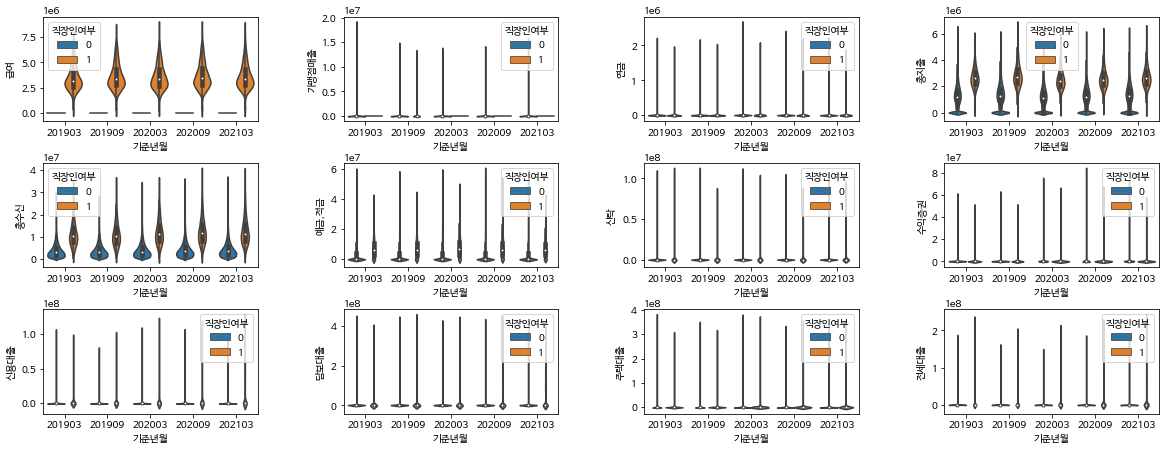

In [ ]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

count=1
for column_name in numcol_list:
  plt.subplot(4,4,count)
  plt.ylabel(column_name)
  sns.violinplot(data['기준년월'], data[column_name], data=data, hue='직장인여부')
  count+=1
plt.show()

In [ ]:
직장인 = data[data['직장인여부']==1]
not_직장인 = data[data['직장인여부']==0]

In [ ]:
# function to make Time slider maps
def Time_slider_subset(mapdata, meandata, column, 직장인): 

  #column=str(column)
  
  directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean{0}/'.format(column)

  if not os.path.exists(directory):
    os.makedirs(directory)

  
  data, cmap = color_scale(meandata, column)
  style_dict = style_dictionary(data)

  map = folium.Map(location=[37.5502, 126.982], zoom_start=11, max_bounds=True)

  g = TimeSliderChoropleth(
      mapdata,
      styledict=style_dict, overlay = True
  ).add_to(map)

  map.add_child(cmap)

  cmap.caption = '평균 {0}'.format(column)

  map.add_child(folium.map.LayerControl())
  if bool(직장인):
    map.save(directory+'직장인dongmean_timeslider_{0}'.format(column))
  else:
    map.save(directory+'not직장인dongmean_timeslider_{0}'.format(column))
  

  display(map)

In [ ]:
# Execute group mean function

dongmean = mean_groupby_dong(path, 직장인)
행정구역_gdf, dongmean_polygon = map_data_preprocessing(path, dongmean)

# Execute mapping functions
numcol_list = ['급여', '연금', '총지출', '총수신', '예금,적금', '신탁', '수익증권', '신용대출', '담보대출','주택대출', '전세대출']

for column_name in numcol_list:
  Time_slider_subset(행정구역_gdf, dongmean_polygon, column_name, 직장인=True)

Output hidden; open in https://colab.research.google.com to view.

## Not 직장인

In [ ]:
# Execute group mean function

dongmean = mean_groupby_dong(path, not_직장인)
행정구역_gdf, dongmean_polygon = map_data_preprocessing(path, dongmean)

# Execute mapping functions
numcol_list = ['가맹점매출','연금', '총지출', '총수신', '예금,적금', '신탁', '수익증권', '신용대출', '담보대출','주택대출', '전세대출']

for column_name in numcol_list:
  Time_slider_subset(행정구역_gdf, dongmean_polygon, column_name, 직장인=False)

Output hidden; open in https://colab.research.google.com to view.

# etc code

In [ ]:
datetime_index = pd.DatetimeIndex(dongmean['time'])
dt_index_epochs = datetime_index.astype(int) // 10**9
dt_index = dt_index_epochs.astype('U10')
dt_index


styledata = {}
n_periods = len(dt_index)
n_sample = len(dt_index)
for i, v in dong_shape.iterrows():
    df = pd.DataFrame(
        {'color': np.array(dongmean['급여']),
          'opacity': 0*np.random.normal(size=n_periods)},
         index=dt_index)
    df.sample(n_sample, replace=False).sort_index()
    styledata[i] = df


max_color = max(dongmean['급여'])
min_color = min(dongmean['급여'])
max_opacity, min_opacity = 1, 1

cmap = linear.YlGnBu_09.scale(min_color, max_color)

def norm(x):
    return (x - x.min()) / (x.max() - x.min())

for i, data in styledata.items():
    data['color'] = data['color'].map(cmap)
    data['opacity'] = 1

styledict = {
    str(nbh): data.reset_index().to_dict(orient="index") for nbh, data in styledata.items()
}

In [ ]:
dongmean_polygon_급여 = dongmean[['행정구역코드', 'time', '급여']]

max_colour = max(dongmean_polygon_급여['급여'])
min_colour = min(dongmean_polygon_급여['급여'])
cmap = linear.YlOrRd_09.scale(min_colour, max_colour)

colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'],
                             index=[0, 25, 62.5, 156.25, 390.6, 1000]
dongmean_polygon_급여['colour'] = dongmean_polygon['급여'].map(cmap)

dongmean_polygon_급여['date_sec'] = pd.to_datetime(dongmean_polygon_급여['time']).astype(int) / 10**9
dongmean_polygon_급여['date_sec'] = dongmean_polygon_급여['date_sec'].astype(int).astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
구역_list = dongmean_polygon_급여['행정구역코드'].unique().tolist()
구역_idx = range(len(구역_list))

style_dict = {}
for i in 구역_idx:
    구역 = 구역_list[i]
    result = dongmean_polygon_급여[dongmean_polygon_급여['행정구역코드'] == 구역]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
    style_dict[str(i)] = inner_dict

In [ ]:
directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/연습/'

if not os.path.exists(directory):
  os.makedirs(directory)


map = folium.Map(location=[37.5502, 126.982], zoom_start=11, max_bounds=True)

g = TimeSliderChoropleth(
    행정구역_gdf,
    styledict=style_dict, overlay = True
).add_to(map)

map.add_child(cmap)
cmap.caption = "평균 급여"

map.save(directory+'plot_dongmean급여_timeslider_2')

In [ ]:
display(map)

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

times= [201903, 201909, 202003, 202009, 202103]
list_columns = ['가맹점매출',	'연금',	'총지출',	'총수신',	'예금,적금',	'신탁',	'수익증권',	'신용대출',	'담보대출',	'주택대출',	'전세대출'	]
for column in list_columns:

  appended_data_dong={}
  for i, year in enumerate(times):
    dongmean = c[c['기준년월']==year ].groupby('행정구역코드')[column].mean().reset_index()
    dongmean['행정구역코드'] = dongmean['행정구역코드'].astype(str)
    appended_data_dong[year] =  dongmean

  appended_data_gu={}
  for i, year in enumerate(times):
    gumean = data[data['기준년월']==year ].groupby('지역구')[column].mean().reset_index()
    gumean['지역구'] = gumean['지역구'].astype(str)
    appended_data_gu[year] = gumean


    # GU 

    directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/gumean{0}/'.format(column)

    if not os.path.exists(directory):
      os.makedirs(directory)


    for year, yearlydata in appended_data_gu.items():
      map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
      folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('지역구', column),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='구 평균 평균 {0}'.format(column),
                nan_fill_color = "White",
                threshold_scale=range(1800000, 6300000,640000),
                key_on='properties.name').add_to(map)
      folium.LayerControl().add_to(map)

      map.save(directory+'plot_gumean_%s_%d.html' %(column, year))

    # DONG
    directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean{0}/'.format(column)

    if not os.path.exists(directory):
      os.makedirs(directory)

    for year, yearlydata in appended_data_dong.items():
      map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
      folium.Choropleth(geo_data=geo_str,
                    data=yearlydata,
                    columns=('행정구역코드', column),
                    fill_color='BuPu',
                    fill_opacity=0.8,
                    line_opacity=0.2,
                    legend_name='동별 평균 {0}'.format(column),
                    nan_fill_color = "Grey",
                    threshold_scale=list(range(200000, 10000001,1400000)),
                    key_on='feature.properties.adm_cd').add_to(map)
      folium.LayerControl().add_to(map)

      map.save(directory+'plot_dongmean_%s_%d.html' %(column, year))
